In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
#import xlsxwriter
import pandas as pd # Excel
import struct # Binary writing

from scipy import interp
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import scipy.io as sio # Read .mat files
import h5py

import time

from grading import *
#from grading_old import regress
from LBP_components import Conv_MRELBP#, MRELBP
from Components import local_normalize

from ipywidgets import FloatProgress
from IPython.display import display

import scipy.signal
import scipy.ndimage
from scipy.stats import spearmanr, wilcoxon

import sklearn.metrics as skmet
import sklearn.decomposition as skdec
import sklearn.linear_model as sklin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut, LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn import neighbors
from sklearn.decomposition import PCA

In [9]:
def pipeline_lbp(impath, savepath, save, pars, dtype='dat'):
    #Start time
    start_time = time.time()
    # Calculate MRELBP from dataset
    # Parameters
    #mapping = getmapping(dict['N']) # mapping
    
    # Save parameters
    writer = pd.ExcelWriter(save + r'\LBP_parameters.xlsx')
    print(pars)
    df1 = pd.DataFrame(pars, index=[0])
    df1.to_excel(writer)
    writer.save()
    
    files = os.listdir(impath)
    files.sort()
    if dtype == 'h5':
        images = Loadh5(impath, files)

    features = None # Reset feature array

    for k in tqdm(range(len(files)), desc='Calculating LBP features'):
        #Load file
        if dtype == 'dat':
            if k > len(files) / 2 - 1:
                break
            file = os.path.join(impath,files[2 * k])
            try:
                Mz = loadbinary(file, np.float64)
            except:
                continue
            file = os.path.join(impath,files[2 * k + 1])
            try:
                sz = loadbinary(file, np.float64)
            except:
                continue
        elif dtype == 'mat':
            file = os.path.join(impath,files[k])
            try:
                file = sio.loadmat(file)
                Mz = file['Mz']
                sz = file['sz']
            except NotImplementedError:
                file = h5py.File(file)
                Mz = file['Mz'][()]
                sz = file['sz'][()]
            
        #Combine mean and sd images
        if dtype == 'h5':
            image = images[k]
            if np.shape(image)[0] != 400:
                image = image[24:-24,24:-24]
        else:
            image = Mz+sz
        #Grayscale normalization
        #image = local_normalize(image,dict['ks1'],dict['sigma1'],dict['ks2'],dict['sigma2'])
        image = localstandard(image,pars['ks1'],pars['sigma1'],pars['ks2'],pars['sigma2'])
        plt.imshow(image)
        plt.show()
        #print(image)
        # LBP
        hist, lbpIL, lbpIS, lbpIR = MRELBP(image,pars['N'],pars['R'],pars['r'],pars['wc'], (pars['wl'], pars['ws']))
        #hist = Conv_MRELBP(image,dict['N'],dict['R'],dict['r'],dict['wr'][0],dict['wr'][1] ,dict['wc'])
        if hist.shape[0] == 1:
            hist = hist.T
        #print(hist2.shape)
        #print(np.sum(abs(hist2-hist)))
        try:
            features = np.concatenate((features,hist),axis=1)
        except ValueError:
            features = hist
        # Save images
        #if dtype == 'dat':
        #    cv2.imwrite(savepath + '\\' + files[2 * k][:-9] + '.png', lbpIS)
        #else:
            #    cv2.imwrite(savepath + '\\' + files[k][:-9] + '.png', lbpIS)

        # Plot LBP images
        #plt.imshow(lbpIS); plt.show()
        #plt.imshow(lbpIL); plt.show()
        #plt.imshow(lbpIR); plt.show()

    # Save features
    writer = pd.ExcelWriter(save + r'\LBP_features_python.xlsx')
    df1 = pd.DataFrame(features)
    df1.to_excel(writer, sheet_name='LBP_features')
    writer.save()
    
    t = time.time()-start_time
    print('Elapsed time: {0}s'.format(t))
    return features
    
    
def pipeline_load(featurepath, gpath, save, choice, comps, modelpath):
    #Start time
    start_time = time.time()
    # Load grades to array
    grades = pd.read_excel(gpath, 'Sheet1')
    grades = pd.DataFrame(grades).values
    fnames = grades[:,0].astype('str')
    g = list(grades[:,choice].astype('int'))
    g = np.array(g)
    #print('Max grade: {0}, min grade: {1}'.format(max(g), min(g)))
    
    # Load features
    features = pd.read_excel(featurepath, 'LBP_features')
    features = pd.DataFrame(features).values.astype('int')
    mean = np.mean(features, 1) # mean feature
    #if features.shape[1] != 36:
    #    features = features.T
    
    #PCA
    # PCA parameters: whitening, svd solver (auto/full)
    #pca, score = ScikitPCA(features.T, comps, True, 'auto')
    pca, score = ScikitPCA(features.T, comps, True, 'auto')
    #pca, score = PCA(features,10)
    
    
    # Regression
    pred1, weights = regress_group(score, g)
    #pred1 = regress_new(score, g)
    pred2 = logreg_group(score, g>1)
    for p in range(len(pred1)):
        if pred1[p] < 0:
            pred1[p] = 0
        if pred1[p] > max(g):
            pred1[p] = max(g)
    #Plotting PCA
    b = np.round(pred1).astype('int')

    # Reference for pretrained PCA
    try:
        _, _, eigenvec, _, weightref, m = loadbinaryweights(save + modelpath)
    except FileNotFoundError:
        print('Model not found')
        
    dataadjust = features.T - mean
    print('Mean vector')
    print(mean)
    print('Weights')
    print(weights)
    #dataadjust = features.T
    #pca2, score2 = ScikitPCA(dataadjust, comps)
    #print(np.sum(np.abs(score2.flatten() - score.flatten())))
    print('n_samples')
    print(dataadjust.shape[0])
    pcaref = np.matmul(dataadjust, 
                       pca.components_.T * np.sqrt(dataadjust.shape[0] - 1) / pca.singular_values_.T)
    print('pcaref')
    print(pcaref[0,:])
    #pcaref = np.matmul(dataadjust, eigenvec)
    #reference = np.matmul(pcaref, weightref)
    reference = np.matmul(pcaref, weights)
    print('prediction')
    print(reference)
    print('Sum of differences to actual grades (pretrained)')
    print(np.sum(np.abs((reference + 1.5).flatten() - g)))
    #print(reference)
    
    # ROC curve
    C1 = skmet.confusion_matrix(g,b)
    MSE1 = skmet.mean_squared_error(g,pred1)
    fpr, tpr, thresholds = skmet.roc_curve(g>0, np.round(pred1)>0, pos_label=1)
    AUC1 = skmet.auc(fpr,tpr)
    AUC2 = skmet.roc_auc_score(g>1,pred2)
    m, b = np.polyfit(g, pred1.flatten(), 1)
    R2 = skmet.r2_score(g,pred1.flatten())
    #fig0  = plt.figure(figsize=(6,6))
    #ax0 = fig0.add_subplot(111)
    #ax0.plot(fpr,tpr)
    mse_bootstrap(g, pred1)
    
    # Save prediction
    stats = np.zeros(len(g))
    stats[0] = MSE1
    stats[1] = AUC1
    stats[2] = AUC2
    tuples = list(zip(fnames, g, pred1, abs(g - pred1), pred2, stats))
    writer = pd.ExcelWriter(save + r'\prediction_python.xlsx')
    df1 = pd.DataFrame(tuples, columns=['Sample', 'Actual grade', 'Prediction', 'Difference', 'Logistic prediction', 'MSE, AUC1, AUC2'])
    df1.to_excel(writer, sheet_name='Prediction')
    writer.save()
    
    # Save calculated weights
    writebinaryweights(save + '\\' + featurepath[-12:-8] + '_weights.dat'
                       , comps, pca.components_, pca.singular_values_ / np.sqrt(dataadjust.shape[0] - 1)
                       , weights, mean)

    # Spearman corr
    rho = spearmanr(g,pred1)
    #Wilcoxon p
    wilc = wilcoxon(g,pred1)
    print('Spearman: {0}, p: {1}, Wilcoxon p: {2}'.format(rho[0], rho[1], wilc[1]))
    
    #print('Confusion matrix')
    #print(C1)
    print('Mean squared error, Area under curve 1 and 2')
    print(MSE1, AUC1, AUC2)#,MSE2,MSE3,MSE4)
    #print('R2 score')
    #print(R2)
    #print('Sample, grade, prediction')
    #for k in range(len(fnames)):
    #    print(fnames[k],a[k],pred1[k])#,pred3[k])
    
    #x = score[:,0]
    #y = score[:,1]
    #fig = plt.figure(figsize=(6,6))
    #ax1 = fig.add_subplot(111)
    #ax1.scatter(score[g<2,0],score[g<2,1],marker='o',color='b',label='Normal')	
    #ax1.scatter(score[g>1,0],score[g>1,1],marker='s',color='r',label='OA')
    #for k in range(len(g)):
    #    txt = fnames[k][0:-4]+str(g[k])
    #    if g[k] >= 2:
    #        ax1.scatter(x[k],y[k],marker='s',color='r')
    #    else:
    #        ax1.scatter(x[k],y[k],marker='o',color='b')

    # Scatter plot actual vs prediction
    fig = plt.figure(figsize=(6,6))
    ax2 = fig.add_subplot(111)
    ax2.scatter(g,pred1.flatten())
    ax2.plot(g,m*g,'-',color='r')
    ax2.set_xlabel('Actual grade')
    ax2.set_ylabel('Predicted')
    for k in range(len(g)):
        txt = fnames[k]
        txt = txt+str(g[k])
        ax2.annotate(txt,xy=(g[k],pred1[k]),color='r')
    plt.show()
    return g, pred2, MSE1
    
def roc_curve_bootstrap(y, preds, savepath=None, n_bootstrap=1000, seed=42):
    """Evaluates ROC curve using bootstrapping

    Also reports confidence intervals and prints them.

    Parameters
    ----------
    y : numpy.array
        Ground truth
    preds : numpy.array
        Predictions
    savepath: str
        Where to save the figure with ROC curve
    n_bootstrap:
        Number of bootstrap samples to draw
    seed : int
        Random seed

    """
    auc = roc_auc_score(y, preds)
    print('No bootstrapping: auc = {0}'.format(auc))
    np.random.seed(seed)
    aucs = []
    tprs = []
    base_fpr = np.linspace(0, 1, 1001)
    for _ in tqdm(range(n_bootstrap), total=n_bootstrap, desc='Bootstrap:'):
        ind = np.random.choice(y.shape[0], y.shape[0])
        if y[ind].sum() == 0:
            continue
        
        aucs.append(roc_auc_score(y[ind], preds[ind]))
        fpr, tpr, _ = roc_curve(y[ind], preds[ind])
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    auc = np.mean(aucs)
    print('Bootstrapping: auc = {0}'.format(auc))
    tprs = np.array(tprs)
    mean_tprs = np.mean(tprs, 0)
    std = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    CI_l, CI_h = np.percentile(aucs, 2.5), np.percentile(aucs, 97.5)

    plt.figure(figsize=(8, 8))
    plt.title(f'AUC {np.round(auc, 2):.2f} 95% CI [{np.round(CI_l, 2):.2f}-{np.round(CI_h, 2):.2f}]')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)
    plt.plot(base_fpr, mean_tprs, 'r-')
    plt.plot([0, 1], [0, 1], '--', color='black')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    plt.close()

    print('AUC:', np.round(auc, 5))
    print(f'CI [{CI_l:.5f}, {CI_h:.5f}]')
    return auc, CI_l, CI_h

def mse_bootstrap(y, preds, savepath=None, n_bootstrap=1000, seed=42):
    np.random.seed(seed)
    mses = []
    rhos = []
    wilcs = []
    for _ in tqdm(range(n_bootstrap), total=n_bootstrap, desc='Bootstrap:'):
        ind = np.random.choice(y.shape[0], y.shape[0])
        if y[ind].sum() == 0:
            continue
        rho = spearmanr(y[ind],preds[ind])
        wilc = wilcoxon(y[ind],preds[ind])
        MSE1 = skmet.mean_squared_error(y[ind],preds[ind])
        mses.append(MSE1)
        rhos.append(rho[0])
        wilcs.append(wilc[1])
        
    mse_m = np.mean(mses)
    rho_m = np.mean(rhos)
    wilc_m = np.mean(wilcs)
    
    
    CI_l_mse, CI_h_mse = np.percentile(mses, 2.5), np.percentile(mses, 97.5)
    CI_l_rho, CI_h_rho = np.percentile(rhos, 2.5), np.percentile(rhos, 97.5)
    CI_l_wilc, CI_h_wilc = np.percentile(wilcs, 2.5), np.percentile(wilcs, 97.5)

    print('MSE: {0}'.format(mse_m))
    print(f'CI [{CI_l_mse:.5f}, {CI_h_mse:.5f}]')
    print('Spearman: {0}'.format(rho_m))
    print(f'CI [{CI_l_rho:.5f}, {CI_h_rho:.5f}]')
    print('Wilcoxon: {0}'.format(wilc_m))
    print(f'CI [{CI_l_wilc:.5f}, {CI_h_wilc:.5f}]')
    return mse_m, CI_l_mse, CI_h_mse

def roc_multi(y, preds, y2, preds2, y3, preds3, savepath=None, n_bootstrap=1000, seed=42):
    # 1
    np.random.seed(seed)
    aucs = []
    tprs = []
    base_fpr = np.linspace(0, 1, 1001)
    for _ in tqdm(range(n_bootstrap), total=n_bootstrap, desc='Bootstrap:'):
        ind = np.random.choice(y.shape[0], y.shape[0])
        if y[ind].sum() == 0:
            continue
        aucs.append(roc_auc_score(y[ind], preds[ind]))
        fpr, tpr, _ = roc_curve(y[ind], preds[ind])
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    auc = np.mean(aucs)
    tprs = np.array(tprs)
    mean_tprs = np.mean(tprs, 0)
    std = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    CI_l, CI_h = np.percentile(aucs, 2.5), np.percentile(aucs, 97.5)
    
    # 2
    aucs2 = []
    tprs2 = []
    for _ in tqdm(range(n_bootstrap), total=n_bootstrap, desc='Bootstrap:'):
        ind = np.random.choice(y2.shape[0], y2.shape[0])
        if y2[ind].sum() == 0:
            continue
        aucs2.append(roc_auc_score(y2[ind], preds2[ind]))
        fpr2, tpr2, _ = roc_curve(y2[ind], preds2[ind])
        tpr2 = interp(base_fpr, fpr2, tpr2)
        tpr2[0] = 0.0
        tprs2.append(tpr2)
    auc2 = np.mean(aucs2)
    tprs2 = np.array(tprs2)
    mean_tprs2 = np.mean(tprs2, 0)
    std2 = np.std(tprs2, axis=0)
    tprs_upper2 = np.minimum(mean_tprs2 + std2, 1)
    tprs_lower2 = mean_tprs2 - std2
    CI_l2, CI_h2 = np.percentile(aucs2, 2.5), np.percentile(aucs2, 97.5)
    
    # 3
    aucs3 = []
    tprs3 = []
    for _ in tqdm(range(n_bootstrap), total=n_bootstrap, desc='Bootstrap:'):
        ind = np.random.choice(y3.shape[0], y3.shape[0])
        if y3[ind].sum() == 0:
            continue
        aucs3.append(roc_auc_score(y3[ind], preds3[ind]))
        fpr3, tpr3, _ = roc_curve(y3[ind], preds3[ind])
        tpr3 = interp(base_fpr, fpr3, tpr3)
        tpr3[0] = 0.0
        tprs3.append(tpr3)
    auc3 = np.mean(aucs3)
    tprs3 = np.array(tprs3)
    mean_tprs3 = np.mean(tprs3, 0)
    std3 = np.std(tprs3, axis=0)
    tprs_upper3 = np.minimum(mean_tprs3 + std3, 1)
    tprs_lower3 = mean_tprs3 - std3
    CI_l3, CI_h3 = np.percentile(aucs3, 2.5), np.percentile(aucs3, 97.5)
    
    ## ROC without bootstrapping
    #sfpr,stpr,_ = roc_curve(y, pred, pos_label=1)
    #dfpr,dtpr,_ = roc_curve(y2, pred2, pos_label=1)
    #cfpr,ctpr,_ = roc_curve(y3, pred3, pos_label=1)

    plt.figure(figsize=(8, 8))
    #plt.title(f'AUC {np.round(auc, 2):.2f} 95% CI [{np.round(CI_l, 2):.2f}-{np.round(CI_h, 2):.2f}]')
    #plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='red', alpha=0.1)
    #plt.plot(base_fpr, mean_tprs, 'r-')
    plt.plot(fpr, tpr, 'r-')
    #plt.fill_between(base_fpr, tprs_lower2, tprs_upper2, color='green', alpha=0.1)
    #plt.plot(base_fpr, mean_tprs2, 'g-')
    plt.plot(fpr2, tpr2, 'g-')
    #plt.fill_between(base_fpr, tprs_lower3, tprs_upper3, color='blue', alpha=0.1)
    #plt.plot(base_fpr, mean_tprs3, 'b-')
    plt.plot(fpr3, tpr3, 'b-')
    plt.plot([0, 1], [0, 1], '--', color='black')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.tight_layout()
    plt.legend(['Surface, AUC: {:0.2f}'.format(auc),
            'Deep Zone, AUC: {:0.2f}'.format(auc2),
            'Calcified, AUC: {:0.2f}'.format(auc3)],loc='lower right')
    plt.rcParams.update({'font.size': 20})
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    plt.close()

    print('AUC:', np.round(auc, 5))
    print(f'CI [{CI_l:.5f}, {CI_h:.5f}]')
    return auc, CI_l, CI_h

#def roc_multi():
#    sfpr,stpr,_ = roc_curve(sgrades>1,surfp_log,pos_label=1)
#    dfpr,dtpr,_ = roc_curve(dgrades>1,deepp_log,pos_label=1)
#    cfpr,ctpr,_ = roc_curve(cgrades>1,calcp_log,pos_label=1)
#    sscore = roc_auc_score(sgrades>1,surfp_log)
#    dscore = roc_auc_score(dgrades>1,deepp_log)
#    cscore = roc_auc_score(cgrades>1,calcp_log)
#
#    plt.figure(figsize=(11,11))
#    plt.plot(sfpr,stpr,color='r')
#    plt.plot(dfpr,dtpr,color='g')
#    plt.plot(cfpr,ctpr,color='b')
#    plt.legend(['surface, AUC: {:0.3f}'.format(sscore),
#                'deep, AUC: {:0.3f}'.format(dscore),
#                'calcified, AUC: {:0.3f}'.format(cscore)],loc='lower right')
#    plt.ylabel('True Positive Rate')
#    plt.xlabel('False Positive Rate')
#    savepath = r'Z:\3DHistoData\Grading\ROC.png'
#    plt.savefig(savepath, bbox_inches='tight')
#    plt.show()

def Loadh5(impath, flist):
    #Image loading
    images = []

    for file in flist:
        h5 = h5py.File(os.path.join(impath,file),'r')
        ims = h5['sum'][:]
        h5.close()
        images.append(ims)
    return images

### Load features

Surface
Model not found
Mean vector
[5.72688889e+04 5.56271111e+04 0.00000000e+00 2.58888889e+01
 6.99388889e+02 3.40286111e+03 5.78780556e+03 3.99458333e+03
 9.67805556e+02 4.29166667e+01 0.00000000e+00 9.79747500e+04
 0.00000000e+00 2.51388889e+01 6.76138889e+02 3.36125000e+03
 5.73769444e+03 3.96708333e+03 9.63388889e+02 4.11666667e+01
 0.00000000e+00 9.81241389e+04 3.96111111e+02 3.27436111e+03
 3.39519444e+03 3.49458333e+03 3.51608333e+03 3.44591667e+03
 3.48161111e+03 3.31977778e+03 3.95000000e+02 8.81773611e+04]
Weights
[ 0.21833304 -0.17095    -0.16523986  0.04792656  0.07719126 -0.19428843
 -0.00188333 -0.00896718  0.04358071 -0.00883337  0.05970043  0.120081
 -0.07163131  0.07726159 -0.03663311  0.01331589 -0.00553508  0.03780488
  0.00808781  0.00293211]
n_samples
36
pcaref
[-0.77072895 -1.32565057 -0.28461352  0.61456064  0.37479378  0.76927817
  0.75705253 -0.69284236  0.76945296  1.64946113  0.84232869 -0.03147201
  1.30707753 -1.04417523 -0.74603337 -0.20645411  0.726991


MSE: 0.9076720842313716
CI [0.55967, 1.30331]
Spearman: 0.12890221669807223
CI [-0.20732, 0.44399]
Wilcoxon: 0.4984530697911988
CI [0.02671, 0.97492]
Spearman: 0.13161327343157125, p: 0.44418344941798216, Wilcoxon p: 0.9373882722307465
Mean squared error, Area under curve 1 and 2
0.9088377840572088 0.5 0.6160990712074303


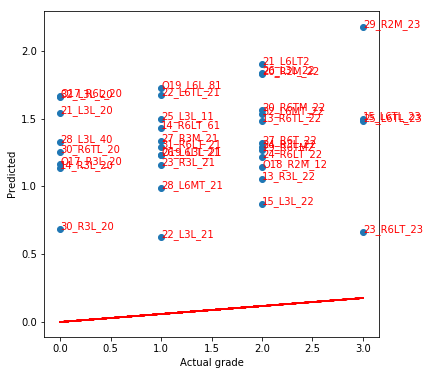

Deep
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[ 0.00053623 -0.12130512  0.09163641  0.17947329 -0.01495443  0.04128701
 -0.00688358 -0.03139516  0.03168333  0.02656029  0.08636531 -0.11792316
 -0.11637444 -0.07236511 -0.11924409  0.00980359  0.01505794 -0.09049831
  0.01399601 -0.05133712]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 -1.10566696 -1.40421327  0.94739918 -0.83650019  2.6329809


MSE: 0.7830702786782059
CI [0.51001, 1.08220]
Spearman: -0.11556585315667385
CI [-0.44061, 0.21936]
Wilcoxon: 0.48191310524663966
CI [0.02085, 0.96271]
Spearman: -0.11986420291183561, p: 0.4862279902818568, Wilcoxon p: 0.8627958052262049
Mean squared error, Area under curve 1 and 2
0.7892486471503776 0.48214285714285715 0.3090909090909091


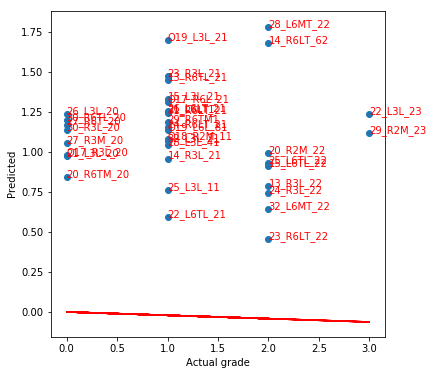

Calcified
Model not found
Mean vector
[5.81461389e+04 6.15698611e+04 0.00000000e+00 6.71388889e+01
 8.85805556e+02 3.29511111e+03 4.35791667e+03 2.62150000e+03
 6.03444444e+02 3.78611111e+01 0.00000000e+00 1.07847222e+05
 0.00000000e+00 1.41916667e+02 1.25319444e+03 3.99341667e+03
 5.60005556e+03 3.52175000e+03 8.88500000e+02 5.26666667e+01
 0.00000000e+00 1.04264500e+05 4.64527778e+02 3.64180556e+03
 4.11163889e+03 4.20391667e+03 4.33130556e+03 4.30022222e+03
 4.18713889e+03 3.81258333e+03 5.36083333e+02 9.01267778e+04]
Weights
[ 0.1587368  -0.1390342   0.02728699  0.21165651 -0.00061089 -0.08483054
 -0.0503314   0.14314262 -0.02267619  0.08044631 -0.05060026 -0.03075264
 -0.02085232  0.08177933  0.01832204 -0.06929693  0.0470269   0.11619451
  0.01019055  0.04186793]
n_samples
36
pcaref
[-0.47296915 -1.30587795 -0.82055674 -0.78527303  0.38094824  2.72480287
 -0.08733553 -0.51648393 -0.35391912  0.92449307 -0.22626058  0.25134558
  0.04401123 -1.37760465  0.48528229  0.32382017  0.37


MSE: 0.6161913346258573
CI [0.35262, 0.94890]
Spearman: 0.3971259473439237
CI [0.06305, 0.67918]
Wilcoxon: 0.48112137968450486
CI [0.01680, 0.97493]
Spearman: 0.40086196821696946, p: 0.015398331214556733, Wilcoxon p: 0.729618806544102
Mean squared error, Area under curve 1 and 2
0.6176130619549698 0.5 0.7192307692307692


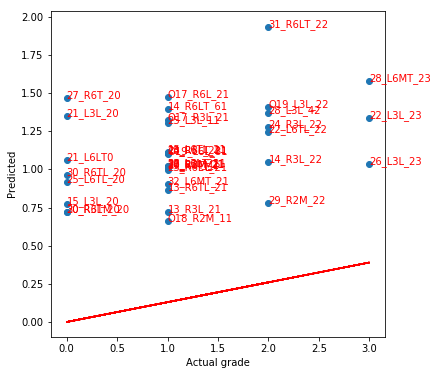

No bootstrapping: auc = 0.6160990712074303



Bootstrapping: auc = 0.6157972617156557


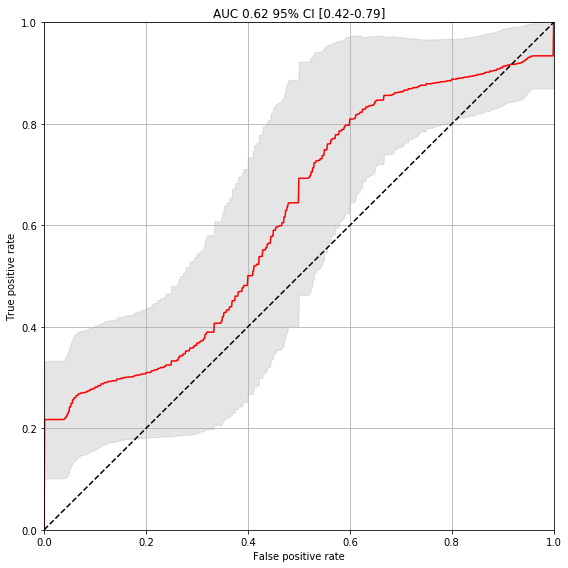

AUC: 0.6158
CI [0.41904, 0.79281]
No bootstrapping: auc = 0.3090909090909091



Bootstrapping: auc = 0.30870772733845464


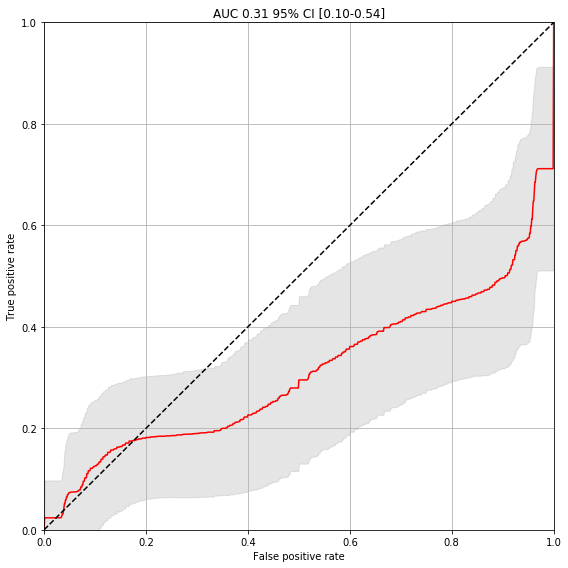

AUC: 0.30871
CI [0.10322, 0.54030]
No bootstrapping: auc = 0.7192307692307692



Bootstrapping: auc = 0.7208287323041802


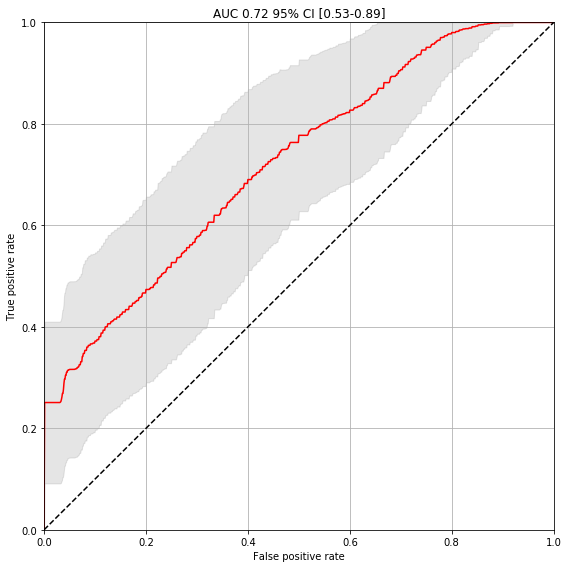

AUC: 0.72083
CI [0.53125, 0.89307]


ValueError: x and y must have same first dimension, but have shapes (18,) and (1001,)

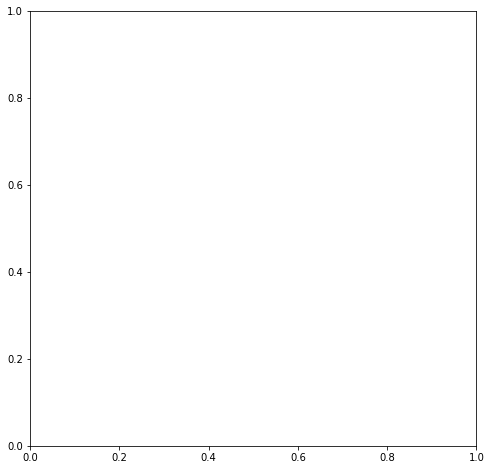

In [10]:
featurepath1 = r'Z:\3DHistoData\Grading\LBP_features_surf.xlsx'
featurepath2 = r'Z:\3DHistoData\Grading\LBP_features_deep.xlsx'
featurepath3 = r'Z:\3DHistoData\Grading\LBP_features_calc.xlsx'
#featurepath3 = r'Z:\3DHistoData\Grading\LBP_features_calc_deeppar.xlsx'
gpath = r'Z:\3DHistoData\Grading\PTAgreiditjanaytteet.xls'
save = r'Z:\3DHistoData\Grading'

surf = 2
deepECM = 8
ccECM = 9

# Check this !!! #
ncomp = 20

print('Surface')
grade1, pred21, mse = pipeline_load(featurepath1, gpath, save, surf, ncomp, r'\surf_weights.dat')
print('Deep')
grade2, pred22, mse2 = pipeline_load(featurepath2, gpath, save, deepECM, ncomp, r'\deep_weights.dat')
print('Calcified')
grade3, pred23, mse3 = pipeline_load(featurepath3, gpath, save, ccECM, ncomp, r'\calc_weights.dat')
#print('{0}, {1}, {2}'.format(mse, mse2, mse3))
roc_curve_bootstrap(grade1>1, pred21)
roc_curve_bootstrap(grade2>1, pred22)
roc_curve_bootstrap(grade3>1, pred23)
roc_multi(grade1>1, pred21, grade2>1, pred22, grade3>1, pred23, r'Z:\3DHistoData\Grading\ROC.png')

Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.017995   -0.11480905  0.09194125]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473]
prediction
[ 0.12481233  0.18013455  0.3205077  -0.05747874 -0.12386753  0.11349322
 -0.05731462 -0.09116226 -0.09389971  0.08818445 -0.10352683 -0.11432633
 -0.09962413 -0.00715493 -0.11228111 -0.10481115  0.0114174   0.12547435
  0.06914888 -0.00849952 -0.07301317 -0.09570455  0.05348318  0.34857276
  0.34430272  0.09243131 -0.16291503  0.0066209  -0.03301649 -0.2153429
 -0.


MSE: 0.719421526942147
CI [0.44880, 1.03633]
Spearman: -0.09113241508312171
CI [-0.40608, 0.21262]
Wilcoxon: 0.44526264875085975
CI [0.01040, 0.97493]
Spearman: -0.09100289138122082, p: 0.5976070273803221, Wilcoxon p: 0.5716788525651493
Mean squared error, Area under curve 1 and 2
0.7237560674834227 0.5 0.46545454545454545


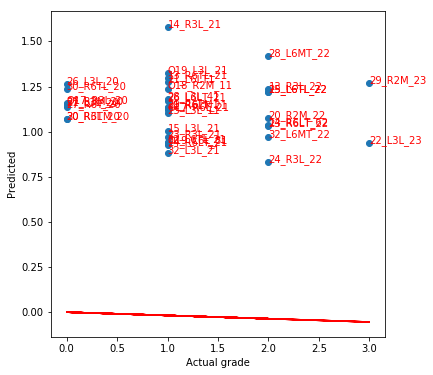

Components: 3, MSE: 0.7237560674834227
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[ 0.00360611 -0.12490125  0.09238745  0.18097843]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304]
prediction
[-0.13333942  0.03120256  0.30350302  0.22702971 -0.07778574 -0.1435104
  0.11722249 -0.32975119 -0.27246452  0.01094381  0.14609127 -0.20492523
 -0.0070153   0.36887745  0.12806227 -0.16218208  0.03398759 -0.11376769
 -0.05447511  0.05885557 -0.13543039 -0.40055221  0.27490736  0.38406697
  0.41957529  


MSE: 0.6735010545369985
CI [0.43053, 0.94583]
Spearman: 0.1441181561092852
CI [-0.18234, 0.44846]
Wilcoxon: 0.46909349273124373
CI [0.01416, 0.96240]
Spearman: 0.14637794364809417, p: 0.3942839257746973, Wilcoxon p: 0.7414588442222838
Mean squared error, Area under curve 1 and 2
0.6793475476343485 0.5 0.4545454545454546


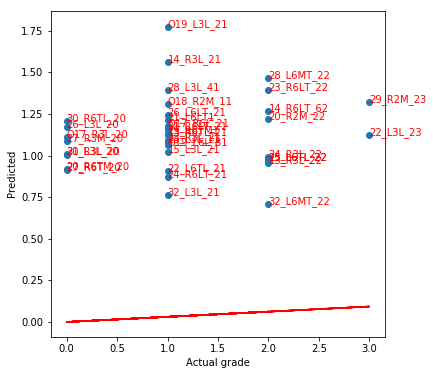

Components: 4, MSE: 0.6793475476343485
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[ 0.0017479  -0.12345792  0.09216612  0.17988397 -0.01275271]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146]
prediction
[-0.11887384  0.05154746  0.28672761  0.23369245 -0.07796587 -0.15131304
  0.1233669  -0.33037569 -0.27967841  0.02580542  0.13852689 -0.23165931
 -0.01320986  0.37550546  0.13795501 -0.15525176  0.02598083 -0.12409517
 -0.04363901  0.05396776 -0.12761922 -0.40817347  0.27610251  


MSE: 0.6802405188573449
CI [0.42858, 0.96507]
Spearman: 0.1245565996522406
CI [-0.19955, 0.43340]
Wilcoxon: 0.47878299854004963
CI [0.01914, 0.96240]
Spearman: 0.12649263809590025, p: 0.46225934726008744, Wilcoxon p: 0.8136975789616672
Mean squared error, Area under curve 1 and 2
0.6862151888070954 0.5 0.44


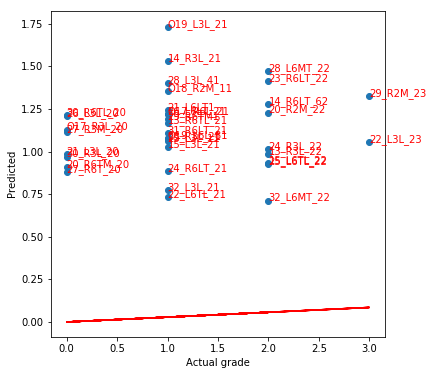

Components: 5, MSE: 0.6862151888070954
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.00216798 -0.12057903  0.09175146  0.17753689 -0.01635021  0.04207236]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016]
prediction
[-0.12249513  0.01038681  0.2896309   0.27181903 -0.03539475 -0.13646918
  0.08371753 -0.34444699 -0.31988826  0.0390682   0.11427249 -0.2276884
 -0.04954552  0.40351005  0.13285956 -0.15787409 -0.01376716 -0.19045916
 -0.0129542   0.05958435 -0.16763455 -0


MSE: 0.697011099625132
CI [0.43271, 0.98707]
Spearman: 0.06184159559043905
CI [-0.29077, 0.39235]
Wilcoxon: 0.479156007816943
CI [0.01997, 0.97493]
Spearman: 0.06214157985060601, p: 0.7188177789993859, Wilcoxon p: 0.7894077402776654
Mean squared error, Area under curve 1 and 2
0.70280302534275 0.5 0.3927272727272727


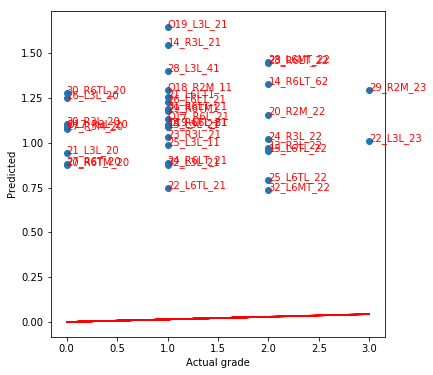

Components: 6, MSE: 0.70280302534275
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.00275506 -0.12011127  0.0916778   0.17719405 -0.01692073  0.0423517
 -0.0076423 ]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737]
prediction
[-0.12924457  0.01174368  0.28087119  0.27394392 -0.02853934 -0.13985524
  0.08758477 -0.35271084 -0.32167427  0.04945881  0.10508704 -0.21222558
 -0.04657712  0.3963804   0.13111914 -0.14232059 -0.01401214 -0.18836531
 -0.01748535  0


MSE: 0.7094346741622348
CI [0.44064, 1.01373]
Spearman: 0.044062877640814964
CI [-0.28971, 0.37316]
Wilcoxon: 0.4725966862941225
CI [0.01690, 0.96239]
Spearman: 0.04294673629675216, p: 0.803592022662406, Wilcoxon p: 0.7533604100137411
Mean squared error, Area under curve 1 and 2
0.7155639205062364 0.5 0.3781818181818181


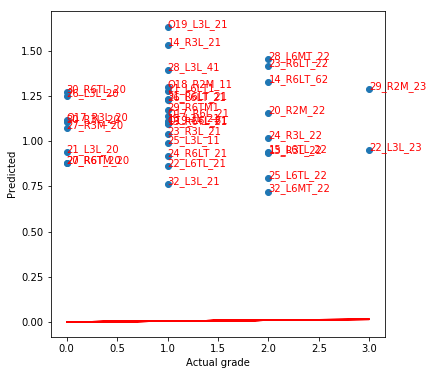

Components: 7, MSE: 0.7155639205062364
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.00410016 -0.11890727  0.09146694  0.17644161 -0.01834201  0.04303815
 -0.00822654 -0.03206918]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182]
prediction
[-0.13126034  0.04431326  0.28601461  0.30642745 -0.05846299 -0.20730947
  0.06165499 -0.35739934 -0.34809181  0.01273263  0.13562633 -0.17794714
 -0.08101813  0.40392285  0.13589372 -0.09889342 -0.04346083 


MSE: 0.7359925616518801
CI [0.44883, 1.05732]
Spearman: -0.059731746949003524
CI [-0.38482, 0.26408]
Wilcoxon: 0.4782446838657635
CI [0.01690, 0.97493]
Spearman: -0.06642244424031443, p: 0.7003150416537622, Wilcoxon p: 0.7533604100137411
Mean squared error, Area under curve 1 and 2
0.7425628217262236 0.5 0.3309090909090909


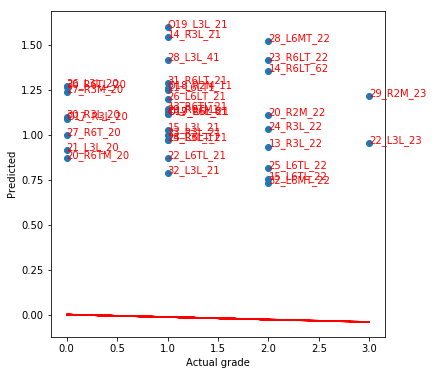

Components: 8, MSE: 0.7425628217262236
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.00720958 -0.11553678  0.09079273  0.17484908 -0.02213406  0.04483108
 -0.00980193 -0.03303631  0.035686  ]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201]
prediction
[-0.07509134  0.00867202  0.34742397  0.33067638  0.01796715 -0.19660427
  0.04819237 -0.40155833 -0.35686621 -0.01307234  0.15666334 -0.17023356
 -0.0266381   0.38520636  0.110766   


MSE: 0.7535736675990434
CI [0.45919, 1.08314]
Spearman: -0.10417983191996256
CI [-0.43036, 0.22373]
Wilcoxon: 0.4693489311462364
CI [0.01838, 0.96240]
Spearman: -0.11088819693341474, p: 0.5196799457043084, Wilcoxon p: 0.7178428857514593
Mean squared error, Area under curve 1 and 2
0.7601087332081456 0.5 0.29818181818181816


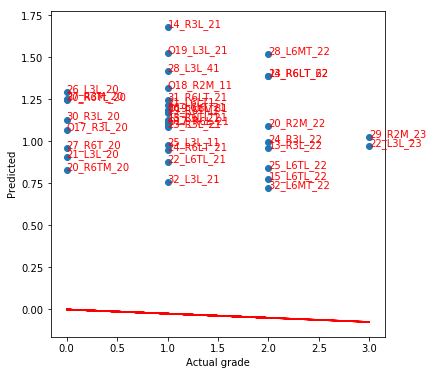

Components: 9, MSE: 0.7601087332081456
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.00695979 -0.11543093  0.0907271   0.17507119 -0.02215428  0.04481923
 -0.00981956 -0.03306869  0.03585218  0.02657448]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475]
prediction
[-0.01480563 -0.01214439  0.33264085  0.31744825 -0.00729424 -0.19886493
  0.02275911 -0.36875279 -0.34533023  0.02294869  0.18207931 -0.16392915
 -0.02979115 


MSE: 0.7978925659591664
CI [0.48099, 1.14653]
Spearman: -0.18899298636004733
CI [-0.49527, 0.15290]
Wilcoxon: 0.47357480871844654
CI [0.01835, 0.97492]
Spearman: -0.19581502272924295, p: 0.25239610967085085, Wilcoxon p: 0.7653208712458196
Mean squared error, Area under curve 1 and 2
0.8048972520571305 0.5 0.2618181818181818


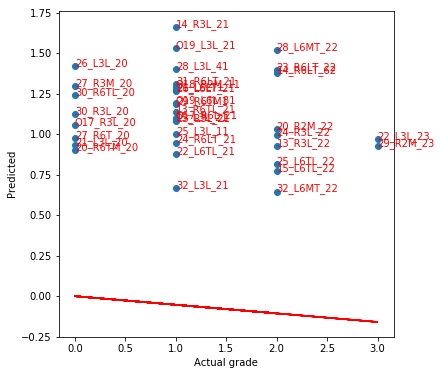

Components: 10, MSE: 0.8048972520571305
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.0068461  -0.11922598  0.09191966  0.17421129 -0.01884845  0.04346499
 -0.0083562  -0.03196014  0.0320399   0.02581857  0.08849297]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439]
prediction
[ 0.03937559 -0.11227463  0.18537672  0.38386156  0.00719918 -0.2515995
  0.0517081  -0.35779174 -0.50691558  0.06628281  0.28184468 -


MSE: 0.789800828785946
CI [0.49299, 1.13346]
Spearman: -0.14170833779054337
CI [-0.44907, 0.19383]
Wilcoxon: 0.4828320984404688
CI [0.01998, 0.97493]
Spearman: -0.14693031324676623, p: 0.39248241511263215, Wilcoxon p: 0.7894077402776654
Mean squared error, Area under curve 1 and 2
0.7959086297218545 0.5 0.2581818181818182


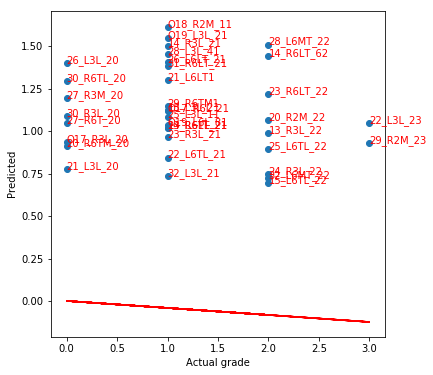

Components: 11, MSE: 0.7959086297218545
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.00468265 -0.11853594  0.09142336  0.17607826 -0.01882805  0.04328274
 -0.00842209 -0.03217434  0.03324986  0.02630089  0.08667668 -0.11743353]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129]
prediction
[ 0.0809445   0.02240228  0.06477288  0.42821039  0.15198353 -0.26160255
 -0.10924551 -0.22326221 -0.5072414  


MSE: 0.7523861642454208
CI [0.47310, 1.06012]
Spearman: -0.052753259738954617
CI [-0.39537, 0.30461]
Wilcoxon: 0.4720815467321985
CI [0.01692, 0.97492]
Spearman: -0.059379731857245745, p: 0.7308399069586828, Wilcoxon p: 0.7178428857514593
Mean squared error, Area under curve 1 and 2
0.7592794952952437 0.5 0.2690909090909091


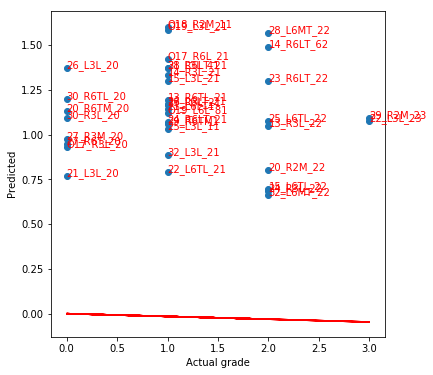

Components: 12, MSE: 0.7592794952952437
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.00159264 -0.11714668  0.09058611  0.17884575 -0.01914712  0.04316412
 -0.00867075 -0.03259826  0.03538641  0.0270721   0.08371194 -0.11877035
 -0.1177858 ]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 -1.10566696]
prediction
[ 2.09577824e-01  1.13809635e-01  9.03209824e-02  4.48644992e-01
  1.01780135e-01 -2


MSE: 0.7587903960930767
CI [0.49961, 1.03958]
Spearman: -0.0074503256120184705
CI [-0.37498, 0.36472]
Wilcoxon: 0.4836287292934598
CI [0.02265, 0.96240]
Spearman: -0.00814745158041279, p: 0.9623855521621781, Wilcoxon p: 0.8999815930539448
Mean squared error, Area under curve 1 and 2
0.7636575768199677 0.5 0.23272727272727273


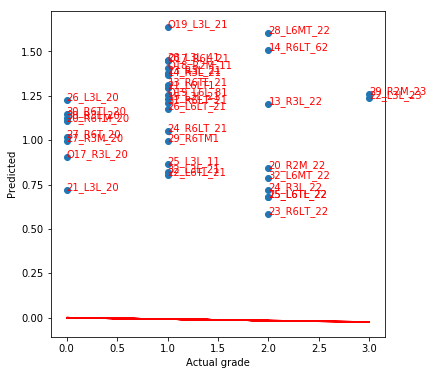

Components: 13, MSE: 0.7636575768199677
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.00033276 -0.12045818  0.09147821  0.17900446 -0.01593223  0.04175474
 -0.00728747 -0.03163767  0.0323345   0.02659577  0.08606297 -0.117975
 -0.11647127 -0.07207155]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 -1.10566696 -1.40421327]
prediction
[ 0.30583059  0.23639587  0.03011713  0.53461815  0.13996601 -


MSE: 0.7522380241448833
CI [0.49144, 1.04455]
Spearman: 0.0065856798967023275
CI [-0.37404, 0.35732]
Wilcoxon: 0.4824426831204698
CI [0.01839, 0.98746]
Spearman: 0.0071808047827366965, p: 0.9668456639415597, Wilcoxon p: 0.8381679283965866
Mean squared error, Area under curve 1 and 2
0.7563122606816034 0.5 0.3018181818181818


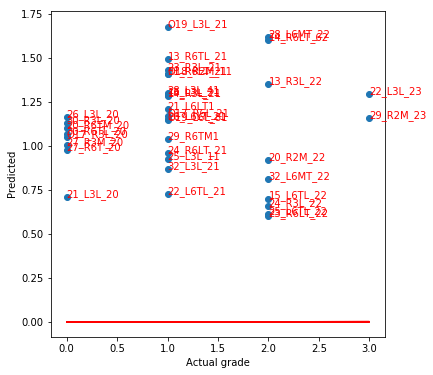

Components: 14, MSE: 0.7563122606816034
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[ 0.0013274  -0.11901737  0.09080751  0.18066498 -0.01670263  0.04193472
 -0.00768693 -0.03206839  0.03418488  0.02715172  0.08383266 -0.11893325
 -0.11801002 -0.07043349 -0.12037335]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 -1.10566696 -1.40421327  0.94739918]
prediction
[ 0.19084088  0.38675465 -0.01091973


MSE: 0.7090593067556887
CI [0.46200, 0.98416]
Spearman: 0.026147397021483287
CI [-0.34103, 0.39872]
Wilcoxon: 0.48713566771486627
CI [0.01995, 0.97493]
Spearman: 0.02817084953227473, p: 0.8704459191231958, Wilcoxon p: 0.8504636310822052
Mean squared error, Area under curve 1 and 2
0.7141125253559362 0.5 0.31272727272727274


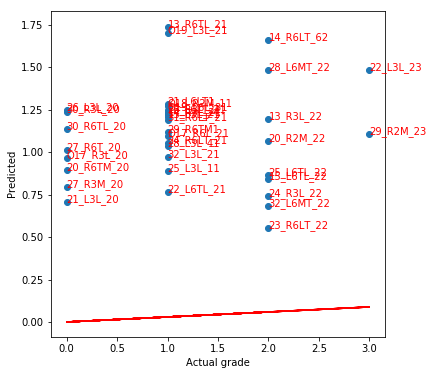

Components: 15, MSE: 0.7141125253559362
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[ 0.00129221 -0.1193628   0.09092188  0.18055104 -0.01641469  0.04182039
 -0.0075579  -0.03196723  0.03382711  0.02707572  0.084169   -0.11880409
 -0.11779995 -0.07069457 -0.12022712  0.00743856]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 -1.10566696 -1.40421327  0.94739918 -0.83650019]
prediction
[ 0.18466775


MSE: 0.7244312512624125
CI [0.47691, 0.99653]
Spearman: 0.002670742210915103
CI [-0.37733, 0.37932]
Wilcoxon: 0.4847241171640152
CI [0.01920, 0.97492]
Spearman: 0.0035904023913683482, p: 0.9834194128847158, Wilcoxon p: 0.8381679283965866
Mean squared error, Area under curve 1 and 2
0.7294990288830908 0.5 0.33818181818181814


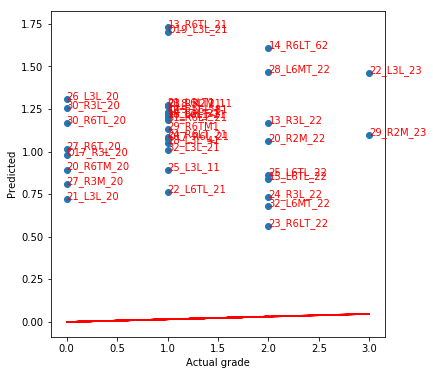

Components: 16, MSE: 0.7294990288830908
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[ 0.00329923 -0.12014429  0.09091366  0.18192755 -0.01516951  0.04115238
 -0.00707476 -0.03175042  0.03351141  0.02723328  0.08378906 -0.11909037
 -0.11823824 -0.07052821 -0.12049728  0.0069895   0.01755757]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 -1.10566696 -1.40421327  0.94739918 -0.83650019  2.63298095]


MSE: 0.765125265081198
CI [0.50056, 1.05142]
Spearman: -0.0691086912067769
CI [-0.44832, 0.31330]
Wilcoxon: 0.4862351617158848
CI [0.01836, 0.97492]
Spearman: -0.07097949342935887, p: 0.6808037662315007, Wilcoxon p: 0.8504636310822052
Mean squared error, Area under curve 1 and 2
0.7709889321329446 0.5 0.2545454545454545


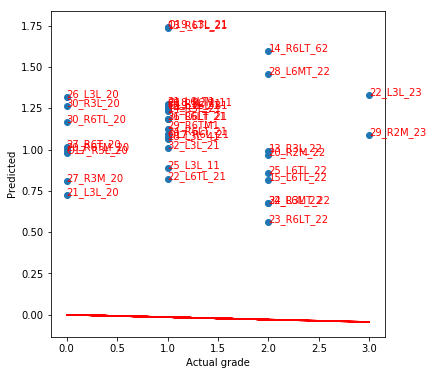

Components: 17, MSE: 0.7709889321329446
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.0004674  -0.1218842   0.09194901  0.17854244 -0.01474051  0.04128067
 -0.00675386 -0.0312201   0.03086004  0.02628373  0.08744562 -0.11744477
 -0.11560873 -0.07314552 -0.11872686  0.01098034  0.01407866 -0.09158703]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 -1.10566696 -1.40421327  0.94739918 -0.83650019 


MSE: 0.7297138890036303
CI [0.47249, 1.00927]
Spearman: -0.032238871178620884
CI [-0.37002, 0.31332]
Wilcoxon: 0.49110273434676005
CI [0.02459, 0.97493]
Spearman: -0.029827958328290886, p: 0.8628951702827017, Wilcoxon p: 0.8875577662678293
Mean squared error, Area under curve 1 and 2
0.7346250380683658 0.5 0.3818181818181818


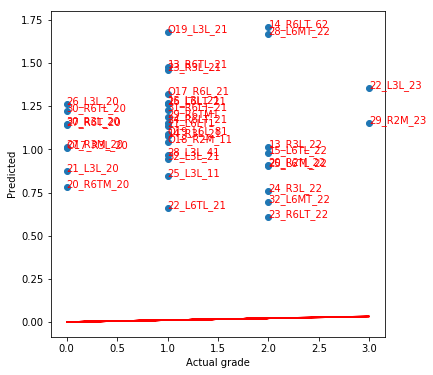

Components: 18, MSE: 0.7346250380683658
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.00059188 -0.12130636  0.09178114  0.17858944 -0.01527436  0.04150789
 -0.0069865  -0.03138827  0.03141515  0.02638191  0.08698324 -0.11760999
 -0.11587986 -0.07277529 -0.11891867  0.01048847  0.01425149 -0.09120023
  0.01360061]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 -1.10566696 -1.40421327  0.94739918


MSE: 0.7757375580495078
CI [0.50634, 1.06019]
Spearman: -0.10453073145633841
CI [-0.44250, 0.24141]
Wilcoxon: 0.4908417764492012
CI [0.02659, 0.97492]
Spearman: -0.10674542494337433, p: 0.5354924196847383, Wilcoxon p: 0.9248998836043245
Mean squared error, Area under curve 1 and 2
0.7815707010127002 0.48214285714285715 0.3054545454545455


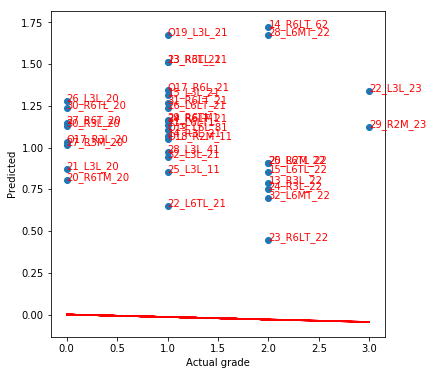

Components: 19, MSE: 0.7815707010127002
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[ 0.00053623 -0.12130512  0.09163641  0.17947329 -0.01495443  0.04128701
 -0.00688358 -0.03139516  0.03168333  0.02656029  0.08636531 -0.11792316
 -0.11637444 -0.07236511 -0.11924409  0.00980359  0.01505794 -0.09049831
  0.01399601 -0.05133712]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 -1.10566696 -1.40421327


MSE: 0.7830702786782059
CI [0.51001, 1.08220]
Spearman: -0.11556585315667385
CI [-0.44061, 0.21936]
Wilcoxon: 0.48191310524663966
CI [0.02085, 0.96271]
Spearman: -0.11986420291183561, p: 0.4862279902818568, Wilcoxon p: 0.8627958052262049
Mean squared error, Area under curve 1 and 2
0.7892486471503776 0.48214285714285715 0.3090909090909091


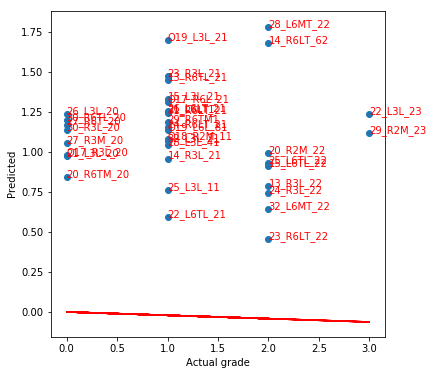

Components: 20, MSE: 0.7892486471503776
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.00134652 -0.12009993  0.09149397  0.17830006 -0.01652972  0.04207935
 -0.00751755 -0.03173652  0.03245705  0.02650875  0.08628837 -0.11781779
 -0.11622933 -0.07218181 -0.11917666  0.00976137  0.0142589  -0.09070007
  0.01413173 -0.05121562  0.01283412]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 -1.10566696


MSE: 0.7859035842039234
CI [0.50679, 1.09957]
Spearman: -0.12257081471552983
CI [-0.44337, 0.22157]
Wilcoxon: 0.4798619793135731
CI [0.01760, 0.96240]
Spearman: -0.12676882289523628, p: 0.46127452380389966, Wilcoxon p: 0.8259116147488036
Mean squared error, Area under curve 1 and 2
0.7924499575460685 0.48214285714285715 0.3018181818181819


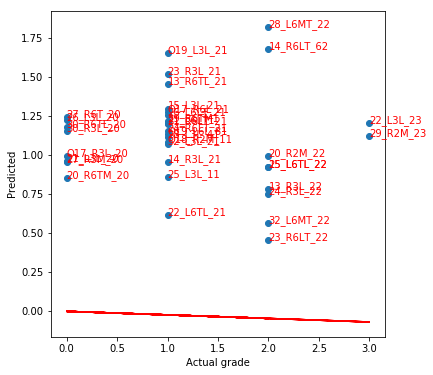

Components: 21, MSE: 0.7924499575460685
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.01336272 -0.11437316  0.09120991  0.17032087 -0.02488863  0.0464466
 -0.01081138 -0.03334082  0.03540725  0.02577914  0.08760115 -0.11646607
 -0.11419581 -0.07242452 -0.11797203  0.01142111  0.00826908 -0.09356615
  0.01370294 -0.05001124  0.01908405 -0.08677929]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0.36790129
 


MSE: 0.7410448529712169
CI [0.48401, 1.01375]
Spearman: -0.01652665333938854
CI [-0.37104, 0.34237]
Wilcoxon: 0.47788622056774416
CI [0.01422, 0.97493]
Spearman: -0.018228196756177765, p: 0.9159648063686967, Wilcoxon p: 0.7653208712458196
Mean squared error, Area under curve 1 and 2
0.7474724754808154 0.48214285714285715 0.32727272727272727


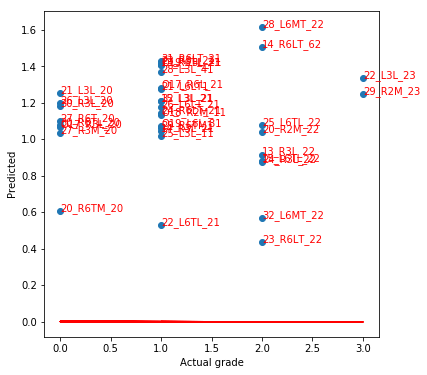

Components: 22, MSE: 0.7474724754808154
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.01828851 -0.1154338   0.09217752  0.16619775 -0.02537539  0.0470407
 -0.01085679 -0.03300232  0.03316878  0.02478507  0.09126793 -0.11473392
 -0.1114416  -0.07497406 -0.11613536  0.01544754  0.00426981 -0.0974786
  0.01128104 -0.04877357  0.0211193  -0.09010586 -0.05054348]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475  0.66522439 -0


MSE: 0.741630850406586
CI [0.48836, 1.01282]
Spearman: -0.05267410536281808
CI [-0.41272, 0.27016]
Wilcoxon: 0.48422984510083517
CI [0.01919, 0.97493]
Spearman: -0.05882736225857369, p: 0.7332520347301303, Wilcoxon p: 0.8015286790618323
Mean squared error, Area under curve 1 and 2
0.7484315956749664 0.48214285714285715 0.3854545454545454


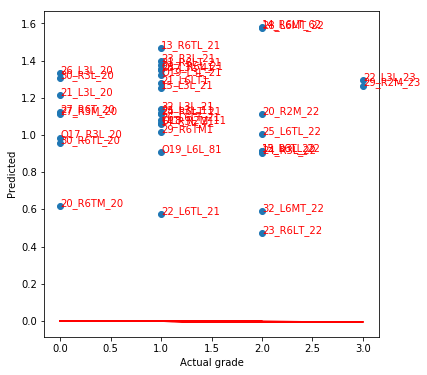

Components: 23, MSE: 0.7484315956749664
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.01908961 -0.116202    0.09252436  0.16537823 -0.02494072  0.04692825
 -0.01063611 -0.03277316  0.0322021   0.02450194  0.09241111 -0.11424631
 -0.11065798 -0.07581694 -0.11560195  0.01668721  0.00334954 -0.09859338
  0.01049457 -0.04844225  0.02135823 -0.09080436 -0.052568    0.02299798]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201  2.27443475 


MSE: 0.7643983348934801
CI [0.50404, 1.04939]
Spearman: -0.10288632271346437
CI [-0.44836, 0.22094]
Wilcoxon: 0.484151416453588
CI [0.01912, 0.97492]
Spearman: -0.1104739197344107, p: 0.5212507718916484, Wilcoxon p: 0.8136975789616672
Mean squared error, Area under curve 1 and 2
0.7715762875732411 0.4642857142857143 0.3672727272727273


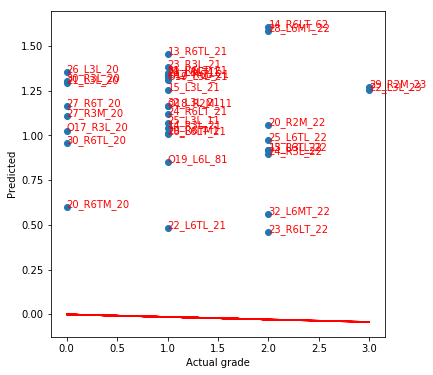

Components: 24, MSE: 0.7715762875732411
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.02232327 -0.13161599  0.08304397  0.1501507  -0.02969847  0.04805937
 -0.0096976  -0.03296224  0.02635444  0.02237082  0.08982681 -0.11917686
 -0.10844906 -0.078717   -0.11671048  0.01671854  0.00525249 -0.09528895
  0.01219525 -0.04729189  0.01959324 -0.08968388 -0.04673009  0.01941335
  0.25352728]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182  1.53555201


MSE: 0.7730526013536787
CI [0.50479, 1.06051]
Spearman: -0.09273807828164643
CI [-0.43166, 0.22940]
Wilcoxon: 0.48744775221102044
CI [0.01920, 0.96271]
Spearman: -0.1001169897593097, p: 0.561264078211045, Wilcoxon p: 0.8381679283965866
Mean squared error, Area under curve 1 and 2
0.7806535893603364 0.4642857142857143 0.3672727272727273


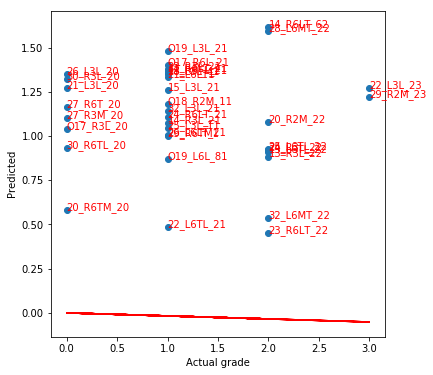

Components: 25, MSE: 0.7806535893603364
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.03277408 -0.11869247  0.07377202  0.15959077 -0.02470888  0.04278689
 -0.01615954 -0.0328079   0.02407654  0.02252145  0.09396507 -0.11770531
 -0.10912654 -0.08034629 -0.1167816   0.01240634  0.00737032 -0.0978451
  0.01310298 -0.04631843  0.01313099 -0.08410938 -0.05122171  0.02072837
  0.28815277  0.11166183]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  0.08864182 


MSE: 0.7832597595099992
CI [0.51476, 1.07244]
Spearman: -0.09435781202478086
CI [-0.43502, 0.23357]
Wilcoxon: 0.48893482876711253
CI [0.01912, 0.97492]
Spearman: -0.10191219095499386, p: 0.5542280115761937, Wilcoxon p: 0.8504636310822052
Mean squared error, Area under curve 1 and 2
0.79140489588985 0.4642857142857143 0.3672727272727273


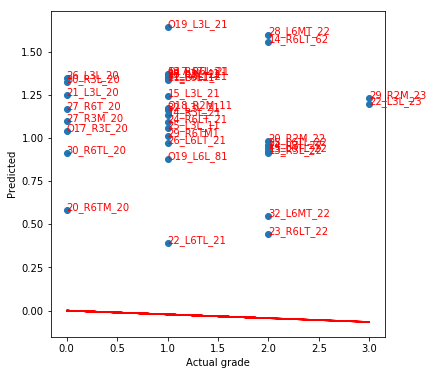

Components: 26, MSE: 0.79140489588985
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.01017373 -0.10693752  0.06940819  0.14916346 -0.02612119  0.04147254
 -0.01295561 -0.03272955  0.03015447  0.02132598  0.09349253 -0.11849637
 -0.10821323 -0.08381716 -0.11498625  0.01064286  0.00869233 -0.10099893
  0.00788957 -0.04561235  0.01335569 -0.08972259 -0.05183447  0.02260657
  0.29713976  0.12042553  0.10425461]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
  0.96566737  


MSE: 0.7837383598843278
CI [0.51696, 1.06715]
Spearman: -0.09030669090271899
CI [-0.42418, 0.23008]
Wilcoxon: 0.4831558699175197
CI [0.01914, 0.97493]
Spearman: -0.09735514176594942, p: 0.5721686654199231, Wilcoxon p: 0.8136975789616672
Mean squared error, Area under curve 1 and 2
0.791720815988967 0.44642857142857145 0.36


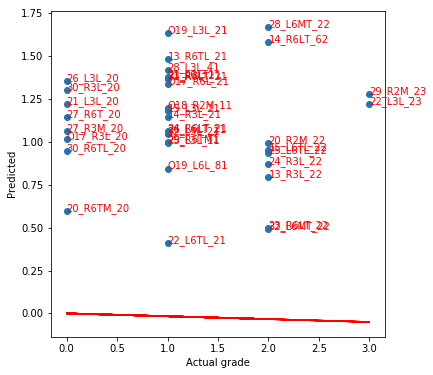

Components: 27, MSE: 0.791720815988967
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.01244058 -0.10632792  0.068333    0.15341119 -0.02669536  0.04226472
 -0.01369566 -0.03311207  0.0288858   0.0203975   0.09321342 -0.11828603
 -0.10792352 -0.08251277 -0.11495241  0.010315    0.00803482 -0.09999144
  0.00937628 -0.04536962  0.01316222 -0.0885481  -0.052788    0.02213771
  0.30323063  0.11434903  0.11018152  0.07757176]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 -0.19666016
 


MSE: 0.7964014189770047
CI [0.52692, 1.08130]
Spearman: -0.11132916880623603
CI [-0.44885, 0.19909]
Wilcoxon: 0.4849808633374329
CI [0.01921, 0.97492]
Spearman: -0.11834518651548746, p: 0.491809716602289, Wilcoxon p: 0.8381679283965866
Mean squared error, Area under curve 1 and 2
0.8046851192864968 0.44642857142857145 0.36


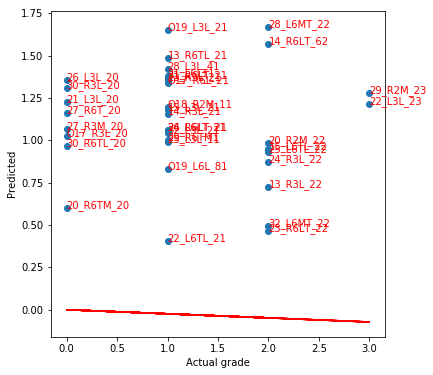

Components: 28, MSE: 0.8046851192864968
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.01530644 -0.10332994  0.06357337  0.13125761 -0.01303632  0.03502821
 -0.01085445 -0.01919316  0.05546887  0.01172472  0.08967939 -0.11575204
 -0.11011423 -0.08246963 -0.11039237  0.00671848  0.02100191 -0.09785996
  0.01067311 -0.04026385  0.00476746 -0.09127557 -0.04408817  0.01997817
  0.26199846  0.11470514  0.08590496  0.15088488 -1.39808599]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 -1.11883146 


MSE: 0.7622486868361454
CI [0.51616, 1.02870]
Spearman: -0.029743351190124095
CI [-0.37983, 0.30961]
Wilcoxon: 0.486676086236807
CI [0.01998, 0.97493]
Spearman: -0.03645639351235553, p: 0.8328180441734265, Wilcoxon p: 0.8751615065669858
Mean squared error, Area under curve 1 and 2
0.7715448064896785 0.4642857142857143 0.36


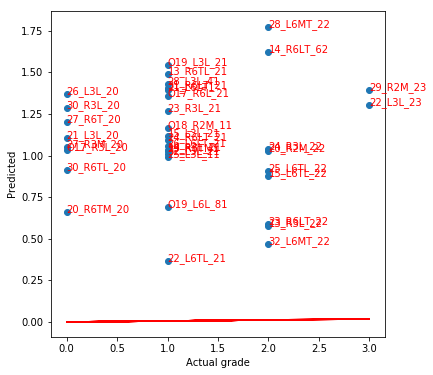

Components: 29, MSE: 0.7715448064896785
Model not found
Mean vector
[6.47636111e+04 6.77323889e+04 0.00000000e+00 1.58333333e+02
 1.37402778e+03 4.34180556e+03 5.77325000e+03 3.38686111e+03
 7.86694444e+02 4.57500000e+01 0.00000000e+00 1.16629278e+05
 0.00000000e+00 4.46194444e+02 4.06252778e+03 1.58167222e+04
 2.34892778e+04 1.45516389e+04 3.09947222e+03 2.76416667e+02
 0.00000000e+00 7.07537500e+04 1.45630556e+03 6.47058333e+03
 6.51830556e+03 7.33683333e+03 7.61416667e+03 7.20855556e+03
 6.46275000e+03 6.50572222e+03 1.50438889e+03 8.14183889e+04]
Weights
[-0.01457836 -0.10416251  0.06450918  0.1291469  -0.01287686  0.03524461
 -0.00928299 -0.01864688  0.055904    0.01268132  0.09196052 -0.11562632
 -0.10817415 -0.0788219  -0.10849087  0.00486123  0.0248356  -0.09655098
  0.00844806 -0.04244961  0.00762125 -0.0922952  -0.04375956  0.01883996
  0.25883831  0.11931603  0.08347112  0.16178652 -1.37228735  0.47652054]
n_samples
36
pcaref
[ 0.09146153 -0.81582543  0.35668473 -1.48371304 


MSE: 0.778014847783722
CI [0.52100, 1.05332]
Spearman: -0.059882286646356093
CI [-0.40986, 0.27471]
Wilcoxon: 0.48808312372470836
CI [0.02173, 0.97493]
Spearman: -0.06766527583732655, p: 0.6949743916078941, Wilcoxon p: 0.8875577662678293
Mean squared error, Area under curve 1 and 2
0.7878230615734121 0.44642857142857145 0.36


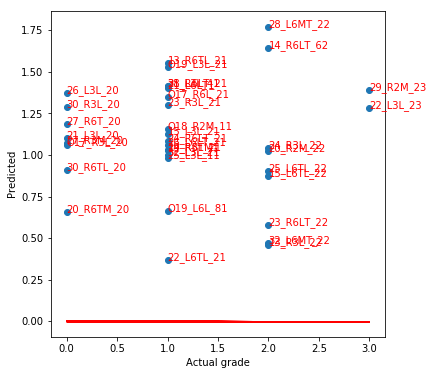

Components: 30, MSE: 0.7878230615734121


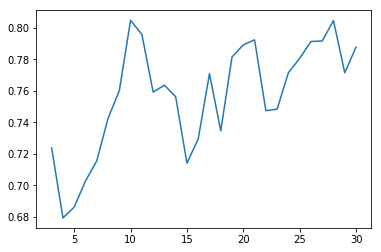

Model not found
Mean vector
[5.81461389e+04 6.15698611e+04 0.00000000e+00 6.71388889e+01
 8.85805556e+02 3.29511111e+03 4.35791667e+03 2.62150000e+03
 6.03444444e+02 3.78611111e+01 0.00000000e+00 1.07847222e+05
 0.00000000e+00 1.41916667e+02 1.25319444e+03 3.99341667e+03
 5.60005556e+03 3.52175000e+03 8.88500000e+02 5.26666667e+01
 0.00000000e+00 1.04264500e+05 4.64527778e+02 3.64180556e+03
 4.11163889e+03 4.20391667e+03 4.33130556e+03 4.30022222e+03
 4.18713889e+03 3.81258333e+03 5.36083333e+02 9.01267778e+04]
Weights
[ 0.01158431 -0.0458508  -0.02867471  0.13758508 -0.01123839 -0.04801109
 -0.08478367  0.00044796 -0.01320122  0.05850362  0.03725097  0.09491147
 -0.01010216 -0.12637799 -0.0528361  -0.15507038  0.00795257  0.08951764]
n_samples
36
pcaref
[-0.47296915 -1.30587795 -0.82055674 -0.78527303  0.38094824  2.72480287
 -0.08733553 -0.51648393 -0.35391912  0.92449307 -0.22626058  0.25134558
  0.04401123 -1.37760465  0.48528229  0.32382017  0.37935528  1.41854846]
prediction
[ 0.


MSE: 0.7965012474828909
CI [0.52967, 1.09611]
Spearman: -0.1565141011864079
CI [-0.47519, 0.17691]
Wilcoxon: 0.49099000589213815
CI [0.01998, 0.97492]
Spearman: -0.16515851000294401, p: 0.33574277680166464, Wilcoxon p: 0.8627958052262049
Mean squared error, Area under curve 1 and 2
0.8029028893938248 0.48214285714285715 0.5272727272727272


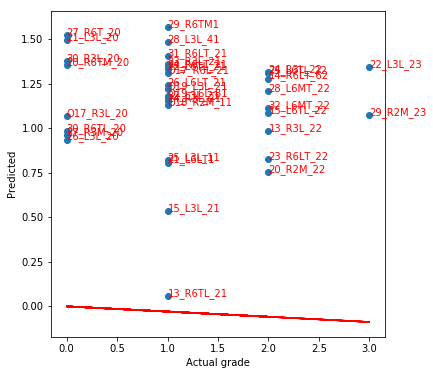

No bootstrapping: auc = 0.5272727272727272



Bootstrapping: auc = 0.5261721157609952


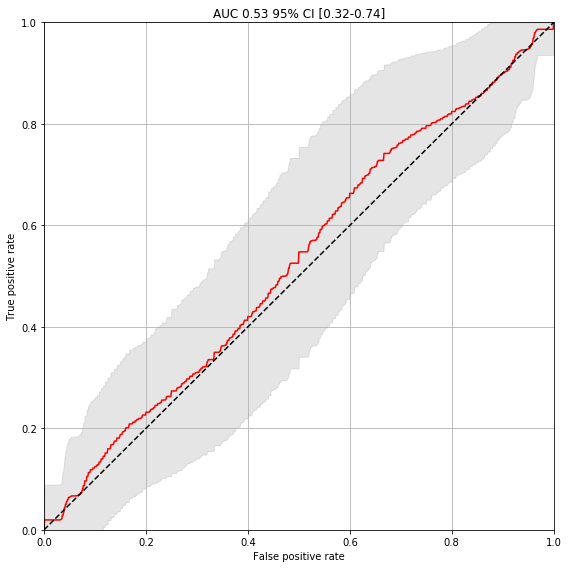

AUC: 0.52617
CI [0.31531, 0.73665]


(0.5261721157609952, 0.3153125, 0.7366535027472527)

In [11]:
featurepath1 = r'Z:\3DHistoData\Grading\LBP_features_surf.xlsx'
featurepath2 = r'Z:\3DHistoData\Grading\LBP_features_deep.xlsx'
featurepath = r'Z:\3DHistoData\Grading\LBP_features_calc.xlsx'
gpath = r'Z:\3DHistoData\Grading\PTAgreiditjanaytteet.xls'
save = r'Z:\3DHistoData\Grading'

total = 1
surf = 2
deep = 5
cc = 6
deepcell = 7
deepECM = 8
ccECM = 9
ccVasc = 10

# Check these !!! #
ncomp = 18
choice = deepECM
# --------------- #
pca = np.zeros(28)
for i in range(28):
    grade, pred2, mse = pipeline_load(featurepath2, gpath, save, choice, i+3, r'\calc_weights.dat')
    pca[i] = mse
    print('Components: {0}, MSE: {1}'.format(i+3, mse))
comp = np.linspace(3, 30, num=28)
plt.plot(comp, pca)
plt.show()

grade, pred2, mse = pipeline_load(featurepath, gpath, save, choice, ncomp, r'\calc_weights.dat')
roc_curve_bootstrap(grade>1, pred2, r'Z:\3DHistoData\Grading\ROC.png')

### Calculate LBP features from .dat mean and std images

{'ks1': 25, 'sigma1': 25, 'ks2': 25, 'sigma2': 15, 'N': 8, 'R': 21, 'r': 13, 'wc': 3, 'wl': 13, 'ws': 5}


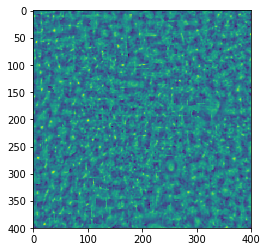

[[-0.45854582 -0.61909724 -0.82985905 ... -0.58677201 -0.44648963
  -0.19247153]
 [-0.61682087 -0.7150588  -0.76490626 ... -0.35631519 -0.06838966
   0.28216131]
 [-0.52990966 -0.45687273 -0.73705777 ...  0.08877178  0.317087
   0.42246972]
 ...
 [-0.26175314 -0.06952055 -1.27410838 ... -0.58401469 -1.02824836
  -1.31568359]
 [-0.98698687 -0.84408869 -1.56242229 ... -1.20674289 -1.66733213
  -1.91607751]
 [-1.63346755 -1.43836749 -2.10265377 ... -1.76649283 -2.1312707
  -2.42529567]]


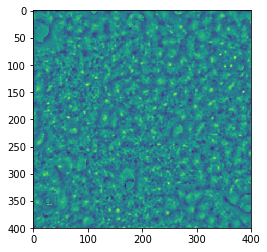

[[-1.97852476 -2.2149193  -2.30250905 ... -1.59447541 -1.14443951
  -0.89899387]
 [-1.52719826 -1.72333903 -1.75733518 ... -1.12260105 -0.90936144
  -0.5954591 ]
 [-1.01441893 -1.15720575 -1.27083877 ... -0.88810289 -0.50813448
  -0.2648257 ]
 ...
 [-1.13439239 -1.2425072  -2.14883755 ...  0.351685    0.59964831
   0.24951004]
 [-1.59672185 -1.8635137  -2.62461412 ...  0.23207235  0.46002952
   0.0432303 ]
 [-1.4101814  -2.08094074 -1.85357838 ...  0.43805254  0.26404998
  -0.10943788]]


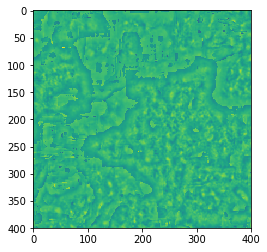

[[-0.06300571 -0.17763699 -0.21295583 ... -0.98497177 -0.88069094
  -1.05633435]
 [-0.10046782 -0.1105085   0.5296174  ... -1.4112686  -1.31367748
  -0.99223953]
 [ 0.58460284  0.59171946  0.44685975 ... -1.78602929 -1.76778756
  -1.08195353]
 ...
 [ 0.03442365  0.13024699  0.12389223 ... -0.06082266 -0.14336032
   1.64249822]
 [-0.63173152 -0.5004114  -0.4021994  ... -0.1481024  -0.13702296
   1.36086995]
 [-1.20517643 -1.06480196 -1.0350679  ... -0.27424383 -0.24679944
   1.00672867]]


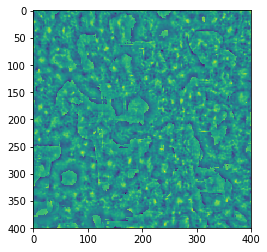

[[-0.52096731 -0.1130327   0.37451763 ...  2.54457571  2.85971596
   2.74687681]
 [-0.2667952   0.26651554  0.69984282 ...  2.27009006  2.67646891
   2.62011662]
 [-0.87915652 -0.24809522  0.20079206 ...  1.8732678   2.35176023
   2.3897327 ]
 ...
 [ 1.42801298  1.12593226  0.87571732 ... -0.34586633 -0.42089663
  -0.51996567]
 [ 1.39800464  1.09616371  0.74041834 ... -0.46203611 -1.1541589
  -1.14593457]
 [ 1.70593967  1.45947224  1.03849804 ... -0.67195142 -1.06174139
  -1.50506736]]


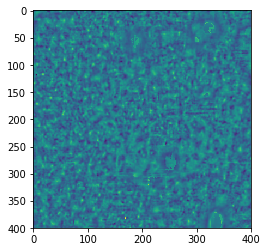

[[-1.88427616 -1.55606683 -0.92098586 ...  1.10913888  1.23465132
   0.72995533]
 [-1.82416802 -1.13058365 -0.68750134 ...  1.05347932  0.70126877
  -0.06422891]
 [-1.26868851 -0.80084687 -0.27187588 ...  1.34768397  0.70226908
  -0.10437277]
 ...
 [-2.00313998 -1.12144245 -0.37539758 ... -1.20574522 -1.26128643
  -1.08604816]
 [-1.8850926  -1.3572975  -0.85167737 ... -0.41993197 -0.4199529
  -0.95309603]
 [-1.95799645 -1.51121454 -1.17935819 ...  0.01010718 -0.04093298
  -0.2350716 ]]


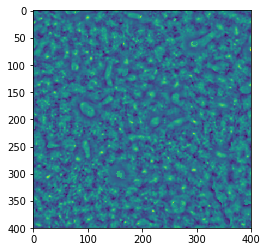

[[-0.89935756 -0.58725341 -0.38034655 ...  1.56646432  1.19918513
   1.12550694]
 [-0.76042236 -0.70226814  0.09204945 ...  1.08018766  0.84153205
   0.55353952]
 [-0.83476722 -0.26111938  0.21372068 ... -0.05375099 -0.24252599
  -0.15832926]
 ...
 [-0.80888306 -0.87662429 -0.83548462 ... -0.7658734  -0.32855077
  -0.38947136]
 [-0.87610111 -0.94088419 -0.94742973 ... -0.53129532 -0.23238808
   0.43011573]
 [-0.99729872 -1.01666907 -1.00481458 ... -0.48259296  0.46770021
   0.84415893]]


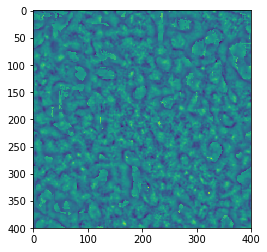

[[-9.13592697e-01 -1.01035968e+00 -1.16252920e+00 ...  2.05296434e+00
   2.19380841e+00  2.21775645e+00]
 [-1.03332878e+00 -1.14189010e+00 -1.24283133e+00 ...  9.91674822e-01
   1.04123685e+00  9.89439417e-01]
 [-1.18566536e+00 -1.26907620e+00 -1.34967385e+00 ...  5.99167453e-02
  -3.11772585e-05 -1.14129797e-01]
 ...
 [-1.38310794e+00 -1.50860162e+00 -1.47961177e+00 ...  1.26573291e+00
   1.63489694e+00  1.94126790e+00]
 [-1.45597587e+00 -1.54775645e+00 -1.53724312e+00 ...  1.13795422e+00
   1.42104375e+00  1.69806137e+00]
 [-1.51516779e+00 -1.56784701e+00 -1.65459310e+00 ...  1.02665781e+00
   1.19562456e+00  1.32004508e+00]]


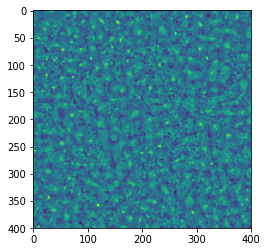

[[-1.0166412  -1.17883168 -1.01012328 ...  0.32896606 -0.22423027
  -0.70666669]
 [-0.32205545 -0.65338821 -0.70964424 ...  0.30112606 -0.16366436
  -0.59703517]
 [ 0.74917654 -0.00430665 -0.45932632 ...  0.03455342 -0.34956889
  -0.78125874]
 ...
 [-0.22131236 -0.60421696 -1.04610717 ... -1.06057035 -1.75389844
  -2.15970001]
 [-0.44230279 -0.68183748 -1.00835886 ... -1.58997386 -2.22368632
  -2.95076621]
 [-0.42504315 -0.6394754  -0.99762255 ... -2.23656584 -3.27454096
  -3.91272088]]


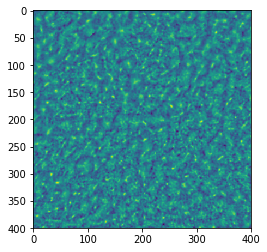

[[-1.99927633 -1.99433893 -2.40775495 ... -1.26334344 -1.51486723
  -1.23728057]
 [-1.61869714 -2.23644661 -2.05847815 ... -1.03134062 -0.7526732
  -0.51714915]
 [-1.13720002 -1.65628329 -1.51041028 ... -0.50829041 -0.3519827
  -0.26502106]
 ...
 [-0.0907156  -0.40811409 -0.72839912 ... -1.02655154 -1.45847758
  -1.70108562]
 [-0.32136581 -1.03068842 -0.88926116 ... -1.9346733  -2.31727946
  -1.95493384]
 [-1.27149927 -2.01055806 -1.67150581 ... -2.26270994 -2.60732887
  -2.22712517]]


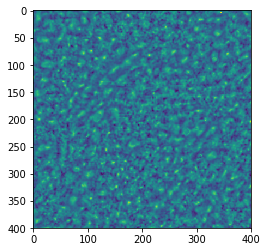

[[-1.34348161 -1.51764701 -1.7181548  ... -0.19432418 -0.3242565
  -0.26398018]
 [-1.30138651 -1.39839003 -1.20035808 ... -0.26529534 -0.38396289
  -0.40811884]
 [-0.98044686 -0.94410789 -1.12101629 ... -0.30633685 -0.44942774
  -0.40445169]
 ...
 [ 0.03962042 -0.00737975 -0.12856554 ... -0.45197086 -1.31171461
  -1.19818157]
 [ 0.03692898  0.04293778 -0.15529046 ... -1.57928592 -2.21914378
  -1.92707088]
 [ 0.05866594 -0.12460365  0.1483297  ... -2.48099203 -2.75813307
  -2.16428709]]


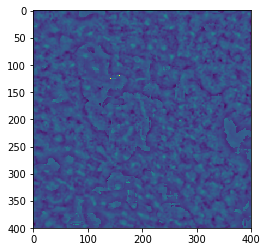

[[-1.36930291 -1.35862506 -1.24112263 ... -1.2627312  -1.29964321
  -1.41390644]
 [-1.34902876 -1.29675964 -1.18433185 ... -1.1074102  -1.24500552
  -1.29934457]
 [-1.31955308 -1.09616155 -0.98163625 ... -0.58577122 -0.8087813
  -1.19031042]
 ...
 [ 0.63546049 -0.22075912 -0.83316464 ... -0.26176228 -0.05418153
   0.20396208]
 [ 0.60274605  0.19201074 -0.19880603 ... -0.22903532 -0.02822605
   0.2417779 ]
 [ 0.38719597  0.36686427  0.13816678 ... -0.14326617  0.07174261
   0.33446601]]


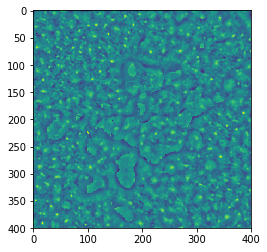

[[-2.35540852 -2.44539797 -2.40342511 ... -1.28820492 -1.04303444
  -0.6925158 ]
 [-2.631077   -2.60801874 -2.46394904 ... -1.42298383 -1.24363014
  -0.94055478]
 [-2.29707435 -2.43008471 -1.85049505 ... -1.51374858 -1.44457665
  -1.22345923]
 ...
 [-0.1229365   0.42944758  0.34972654 ... -0.06114457  0.71839485
   0.49576643]
 [ 0.91604379  1.36917072  0.70478429 ... -0.05176132  0.70722431
   0.66480226]
 [ 2.1928854   2.81460929  1.6251951  ...  0.20119823  0.4128188
   0.94126856]]


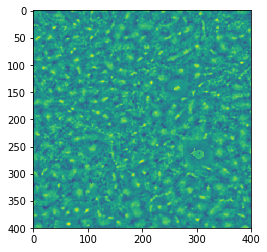

[[-5.21507065 -3.70689542 -2.54816229 ... -0.49462809 -0.55261787
  -0.90663187]
 [-3.96352821 -2.53231482 -1.24047395 ... -0.11107537 -0.30889294
  -0.95741232]
 [-2.78391852 -1.46524256 -0.44660243 ... -0.25442997 -0.52480562
  -1.21051813]
 ...
 [-0.54980378 -0.4867057   0.02910732 ... -0.98806025 -0.98325007
  -0.94464064]
 [-0.50632252 -0.14787872  0.19892718 ... -0.76299471 -0.90203256
  -0.83991941]
 [-0.49675213  0.06816098  0.55138998 ... -0.51644346 -0.88428808
  -0.82038809]]


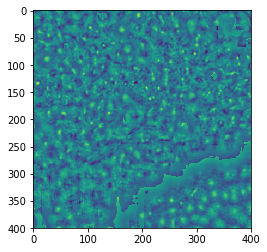

[[-0.5158424  -0.62218142 -0.69731606 ...  0.08556513 -0.36033401
  -0.81574492]
 [-0.72666816 -0.78148162 -0.72378795 ...  0.67573727  0.07955142
  -0.59424287]
 [-1.02991341 -1.04879973 -0.90847761 ...  1.05702451  0.3379865
  -0.44033904]
 ...
 [-0.92050561 -0.84579779 -0.95205546 ...  1.49638777  1.52923428
   1.62852459]
 [-0.99173306 -1.00507148 -1.01486297 ...  1.9281358   1.86090981
   2.02286128]
 [-0.96659222 -0.95655469 -1.02692931 ...  2.37360365  2.16946778
   2.21871481]]


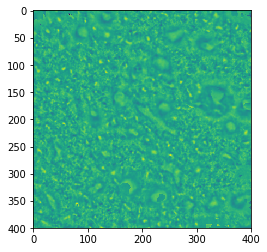

[[-1.80736258 -1.69223214 -1.50979347 ... -0.23747633 -0.29930157
  -0.33229146]
 [-1.85196724 -1.78009963  1.60459636 ... -0.16022041 -0.1987853
  -0.21867526]
 [-1.81690767  0.95705897  0.7674658  ... -0.13594668 -0.17544962
  -0.16549332]
 ...
 [ 1.85989621  1.69129095  0.83727904 ... -1.08473525 -1.06230465
  -1.2230175 ]
 [ 1.86414729  1.56450483  0.8621892  ... -1.67630986 -1.65455999
  -1.71413751]
 [ 1.63940795  1.46937746  1.04291947 ... -2.35412781 -2.35530278
  -2.39037275]]


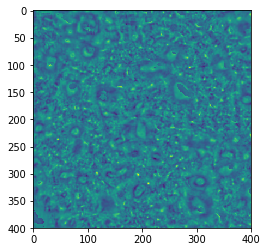

[[-1.89279043 -1.1131891  -0.86281734 ... -1.08119296 -1.13450078
  -0.88509726]
 [-1.4865131  -1.25585824 -0.84665799 ... -0.91791538 -1.04302954
  -0.74575179]
 [-1.21821857 -1.13652076 -1.22147271 ... -0.78949426 -0.89544843
  -0.44410036]
 ...
 [ 0.07687159 -0.03655498 -0.08461751 ... -0.68515322 -0.38868852
   0.08714291]
 [ 0.159593    0.01538696 -0.10535417 ... -0.31281838 -0.89181753
  -0.81272799]
 [ 0.31813433  0.14111679 -0.11499483 ... -0.45076601 -0.6105057
  -1.07608226]]


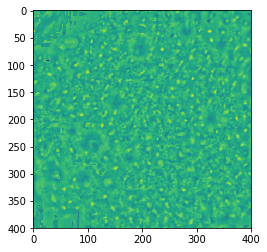

[[-0.65982564 -0.4523788  -0.19436137 ...  0.2679778   0.19186399
   0.19203041]
 [-0.63016527 -0.45417578 -0.23218703 ...  0.19211579  0.12291302
   0.19357408]
 [-0.61637137 -0.4610387   1.22568736 ...  0.10900327  0.0499429
   0.1295377 ]
 ...
 [ 0.39374723 -1.27282437 -1.05773804 ...  0.64867158  0.70078935
   0.7722116 ]
 [ 2.80528779 -0.63638003 -0.99493611 ...  0.59072551  0.62303023
   0.68077111]
 [ 4.16974022  3.35742153 -0.68083762 ...  0.54577657  0.55911232
   0.59184085]]


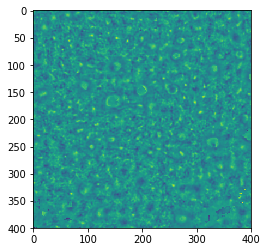

[[ 2.26913001  1.37393902  0.90972303 ...  0.54466019  1.17963963
   0.82240605]
 [ 2.76327025  2.31111154  1.74331733 ...  0.09993512  0.7254295
   0.60950729]
 [ 3.2001073   2.90052694  2.09277569 ... -0.26262097  0.47549768
   0.59004205]
 ...
 [ 0.46410603  0.41575912  0.47653198 ... -0.08437267 -0.382853
  -0.43897253]
 [-0.05977819  0.0497615  -0.04679019 ...  0.35890955 -0.50707718
  -0.7035795 ]
 [-0.39423082 -6.0911941  -5.61054763 ...  0.06259761  0.00850301
  -0.15810314]]


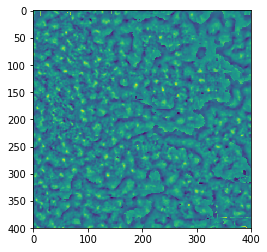

[[ 2.23636756  0.5229748   0.34824417 ...  0.82379968  0.70170412
   0.5996161 ]
 [ 1.87362652  0.16209739 -0.04079985 ...  0.90534055  0.77668695
   0.6418397 ]
 [ 1.61325416  1.47010287  1.41496272 ...  1.00311561  0.88780591
   0.6550917 ]
 ...
 [-1.36548033 -1.1768018  -0.93217096 ...  0.72300706  0.89987814
   0.72248441]
 [-1.32158959 -1.2326703  -1.25656795 ...  0.84208077  0.84402071
   0.90479367]
 [-1.15481745 -1.07674574 -1.06823604 ...  0.83231559  0.74805572
   0.7569799 ]]


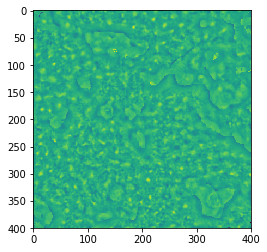

[[-0.21998355  0.1969461   0.55396151 ... -0.3998712  -0.36006504
  -0.4512608 ]
 [-0.24450847  0.28289492  1.14271928 ... -0.60373277 -0.63660692
  -0.64314208]
 [-0.50735393  0.15197646  1.05497342 ... -1.01201741 -1.04304234
  -1.11654578]
 ...
 [-1.40015795 -1.39279819 -1.4049397  ... -0.73488353 -1.17288126
  -1.19498603]
 [-1.39617821 -1.38979655 -1.44301985 ... -0.84253169 -1.40478964
  -1.57800727]
 [-1.37240081 -1.40915412 -1.46190959 ... -0.97023572 -1.47938773
  -1.79549953]]


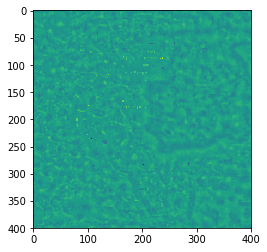

[[ 2.21606515  2.31584266  3.22940627 ... -1.20003398 -1.40849735
  -2.32428202]
 [ 0.0135424   0.29245299 -0.01161459 ... -0.53050101 -0.91228786
  -1.88452086]
 [-0.3986595  -0.30229152 -0.80205762 ...  0.37662478 -0.79707771
  -1.15769885]
 ...
 [ 4.36429128 -0.90106484 -0.85146189 ... -1.19789449 -1.18993606
  -1.24764905]
 [-0.91822168 -1.10975217 -1.11545869 ... -1.15106017 -1.32361057
  -1.68282252]
 [-1.28157988 -1.20399435 -1.03898484 ... -1.16664838 -1.41952821
  -1.91746498]]


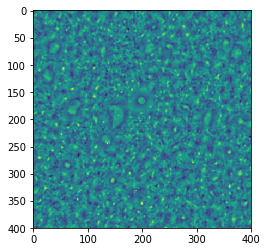

[[-0.96773047 -0.80369528 -0.67128189 ... -0.52662939 -0.63906773
  -0.21466096]
 [-1.35323111 -0.99812395 -0.55916585 ... -0.57311566 -0.07206875
  -0.01786825]
 [-1.79768988 -1.39642731 -0.90968857 ... -0.11564201  0.37696826
   0.48064444]
 ...
 [-1.18447044 -0.57661097 -0.10700837 ... -1.36429278 -1.19627729
  -0.95772985]
 [-1.12445019 -0.62918366 -1.00911939 ... -1.5889392  -1.42709878
  -1.23963769]
 [-1.07944435 -1.20045294 -1.27527985 ... -1.45465444 -1.7235893
  -1.57131952]]


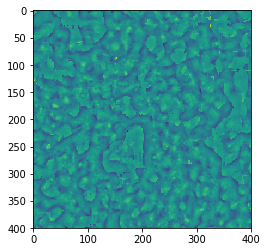

[[ 0.58624052  0.76266224  0.76851305 ... -0.61921416 -0.49070812
  -0.25420113]
 [ 0.70333687  0.79730295  0.80705381 ... -0.31630827 -0.25232684
  -0.09850278]
 [ 0.78159546  0.81038038  0.82619459 ... -0.04538323 -0.03671914
   0.04056162]
 ...
 [-0.79980545 -0.82418501 -0.83237393 ... -1.27549514 -1.05767408
  -0.97862599]
 [-1.55698041 -1.69004548 -1.60936065 ... -0.94240186 -0.85567769
  -0.93998708]
 [-2.5602785  -2.56080974 -2.21479312 ... -0.48193905 -0.6636201
  -1.00000899]]


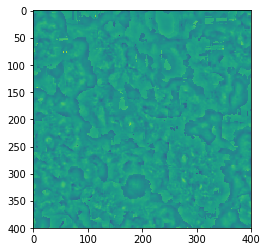

[[ 0.56101638  0.33704491  0.19513861 ... -0.84612014 -0.66744798
  -0.51862881]
 [ 0.34774093  0.07668599 -0.02623144 ... -0.67326811 -0.5955798
  -0.49964409]
 [ 0.1052536   0.11398304  0.11748536 ... -0.43357665 -0.40930118
  -0.30169955]
 ...
 [ 0.97628928  1.0612079   1.09988866 ... -0.73415968 -0.78994179
  -0.48684323]
 [ 0.93129425  1.02023991  1.06244686 ... -1.21450033 -1.28112591
   0.01574405]
 [ 0.90541948  1.05811056  1.09043136 ... -1.17454739 -1.23903087
   2.36339505]]


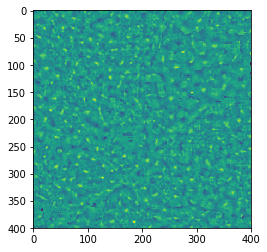

[[-2.61863152 -2.72700743 -2.40596611 ... -1.69227547 -1.60529183
  -1.94826866]
 [-2.56332834 -2.89860341 -2.31517478 ... -1.30241861 -1.58726963
  -1.60915845]
 [-1.53009357 -2.20235638 -2.39763987 ... -1.27492866 -1.26709251
  -1.36364845]
 ...
 [-1.99394471 -1.39695912 -1.31298089 ... -1.51005635 -0.26951571
   0.76067854]
 [-2.50466341 -2.35608442 -2.11657562 ... -1.29820318 -0.89565457
   0.21074096]
 [-3.16144033 -2.75112721 -2.45715989 ... -1.94871659 -1.59608783
  -0.52420718]]


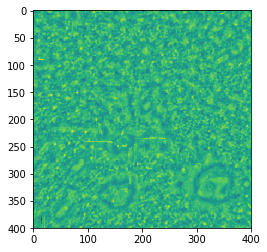

[[-1.75639914 -1.45140595 -1.13672619 ... -1.51640071 -1.6011722
  -1.63140299]
 [-0.95542984 -0.85542958 -0.66896133 ... -1.79799589 -2.03660689
  -2.06374587]
 [-0.65389127 -0.5764486  -0.71769403 ... -1.18044804 -1.46632563
  -1.74386145]
 ...
 [-2.61567756 -1.24428424 -0.25892084 ...  0.40162965  0.55667981
   0.45878015]
 [-2.64679045 -1.55639751 -0.68924499 ...  0.81199593  0.85950955
   0.69107873]
 [-2.03597408 -1.04843136 -0.82796539 ...  0.90144843  1.03670346
   0.78494305]]


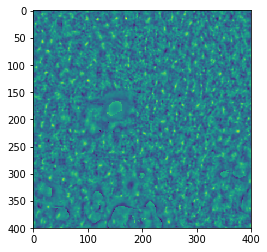

[[-1.03231996 -1.27376829 -0.31399772 ...  0.2079837   0.33676756
   0.38024018]
 [-1.18504191 -1.17271023 -0.41328604 ...  0.19357777  0.11954781
   0.11169496]
 [-1.78061815 -1.01498387 -0.31126533 ... -0.10818354 -0.12580897
  -0.15930164]
 ...
 [ 0.05093263  0.13920613  0.32940628 ...  1.39282676  2.04263955
   2.41834571]
 [-0.36074114 -0.17052565  0.1398692  ...  0.71888586  1.05919655
   1.31580902]
 [-0.24869968 -0.0782189   0.10934206 ...  0.27384121 -0.03569038
   0.0695282 ]]


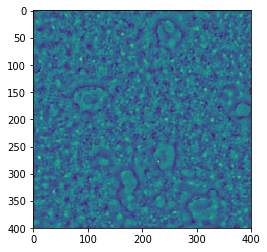

[[-2.83882238 -2.4610528  -2.19530118 ... -0.33322689 -0.08770656
   0.15379297]
 [-2.21875141 -1.79492328 -1.82003369 ...  0.23105166  0.39777405
   0.54835009]
 [-2.07574345 -1.64148331 -1.16037759 ...  0.30583336  0.44994132
   0.59792037]
 ...
 [-0.82839835 -0.91433214 -0.84758284 ... -0.94780923 -0.90278514
  -0.87474161]
 [-0.98579843 -0.97063702 -0.97599191 ... -1.13183404 -1.06663102
  -1.02547408]
 [-1.03827254 -1.06738357 -0.96872058 ... -1.14978587 -1.1940146
  -1.27965925]]


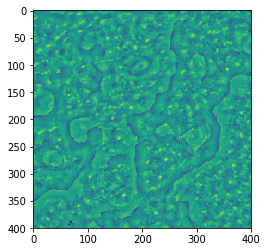

[[-1.01801049 -0.6583149  -0.33612505 ... -1.73336859 -2.39204046
  -3.13309444]
 [-0.88255325 -0.58878429 -0.38176858 ... -1.8549582  -2.15392685
  -2.80425197]
 [-0.72614375 -0.4692953  -0.38124371 ... -1.52834105 -1.6507379
  -2.19273746]
 ...
 [-0.81306051 -1.1392776  -1.48144169 ...  0.17073735 -0.61503065
  -0.92983738]
 [-1.59658057 -1.91335994 -1.58537446 ... -0.33696296 -0.68563849
  -0.70878055]
 [-1.58599225 -1.76371984 -1.34443435 ... -1.05420192 -0.93589939
  -0.49790754]]


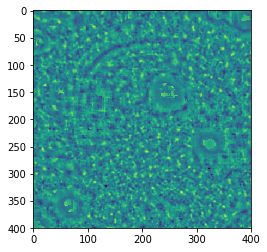

[[-1.74454499 -1.34869449 -1.15619003 ... -0.60472313 -0.70727491
  -0.77575582]
 [-1.43159254 -1.11030515 -0.83082188 ... -0.51711886 -0.63129184
  -0.6994454 ]
 [-1.39605864 -0.99817695 -0.64723172 ... -0.57143177 -0.67619367
  -0.73332218]
 ...
 [ 0.99693041  0.9539581   0.99323798 ...  1.09266457  1.01381743
   1.74562946]
 [ 1.11909532  1.06851105  1.08297778 ...  2.15885921  2.18928526
   2.18371105]
 [ 1.22381799  1.1483724   1.14108224 ...  2.54533117  2.57892643
   2.59731682]]


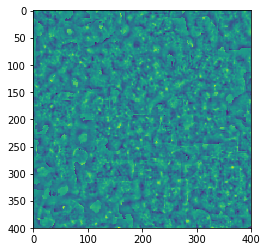

[[-0.14138565  0.52435906  0.67829117 ... -2.0156025  -1.63134588
  -1.92371521]
 [-0.60164684 -0.15151924  0.47789675 ... -1.41035756 -1.46315411
  -1.51488678]
 [-0.46554175 -0.66074222 -0.17012305 ... -1.08420502 -0.87558332
  -1.3073336 ]
 ...
 [-1.7231417  -0.78915575 -0.44630034 ... -0.33815511  0.75368612
  -2.28203834]
 [-1.69315156 -0.82519939 -0.55055991 ... -2.32592626 -2.24826068
  -2.89912705]
 [-1.67000699 -1.42052005 -1.2066355  ... -2.60723202 -2.52471138
  -3.05561474]]


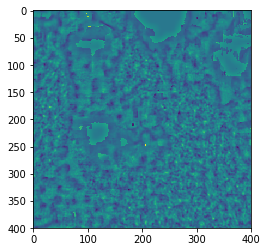

[[-1.01446814 -1.11257358 -0.90230736 ...  0.14128414  0.08894283
   0.03192543]
 [-0.93080472 -0.68679534 -0.45698086 ...  0.13952215  0.08767434
   0.03154852]
 [-0.49593039 -0.22127515 -0.26611534 ...  0.1366231   0.08571811
   0.03048789]
 ...
 [-0.40080351 -0.42970675 -0.53742485 ... -0.59473903 -0.35371996
  -0.13089987]
 [-0.71441265 -0.87053486 -1.05450943 ... -0.66855126 -0.18014472
  -0.15434484]
 [-1.1555561  -1.38720625 -1.61698541 ... -0.77200166 -0.12175779
   0.06903575]]


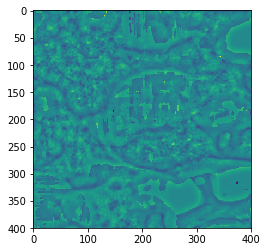

[[ 1.80951961  1.8143238   1.82393845 ... -1.52570075 -1.26169276
  -0.91163372]
 [-0.14601958  1.81990384  1.82948262 ... -1.1359545  -0.87078684
  -0.45335108]
 [-0.30002649 -0.22957454 -0.19723384 ... -0.7014681  -0.38517491
  -0.01319319]
 ...
 [ 0.80364156  0.76257379  1.14496644 ... -0.15200342 -0.56446022
  -1.07501535]
 [ 1.10852036  0.77683716  1.21212673 ... -0.38326509 -0.71887487
  -1.182714  ]
 [ 1.24361305  1.10141064  1.24246607 ... -0.67836262 -0.91764543
  -1.30552344]]


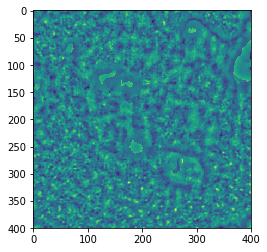

[[-0.40611791  0.24162776  0.60183035 ... -0.92849612 -1.38652081
  -1.87104305]
 [ 0.32664132 -0.04353127  0.22731723 ... -0.91041845 -1.45589481
  -2.12169889]
 [-0.05101473 -0.32435899 -0.13487642 ... -0.52544688 -1.26278617
  -2.11085157]
 ...
 [ 0.92443495  1.09127016  1.2884726  ...  1.49606751  2.0591891
   1.9357855 ]
 [ 1.21282377  1.49321174  1.77522227 ...  1.91986643  1.97455625
   1.91703447]
 [ 1.34365377  1.70438833  1.95244864 ...  2.04779172  2.06329115
   1.96301476]]


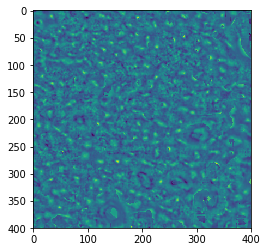

[[-1.46418524 -0.71065397 -2.00893627 ...  0.57026432  1.6120665
   1.8017399 ]
 [-0.76708517 -1.86360625 -2.51928123 ...  0.65799381  2.22969281
   2.24662235]
 [-1.98174495 -2.13583616 -2.18609908 ...  0.51754574  0.90101224
   2.93645516]
 ...
 [-0.1853018  -0.19901639  0.09099855 ... -0.59724634 -0.32452398
  -0.29228154]
 [-0.79796374 -0.30520694 -0.15833737 ... -0.53103735 -0.49981983
  -0.39944171]
 [-0.59517798 -0.21830684 -0.375856   ... -0.47085167 -0.35217202
  -0.31805977]]


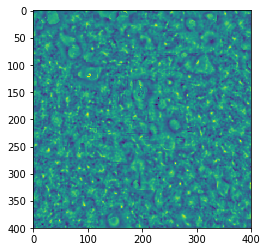

[[-1.01981368 -0.58470866 -0.56375315 ...  0.07807226 -0.48090569
  -0.38614241]
 [-1.23881875 -0.86527011 -0.95284602 ... -0.27147056 -0.26423801
  -0.53534123]
 [-1.2183748  -0.97385176 -1.51272501 ... -0.01809293 -0.51533159
  -0.46372981]
 ...
 [-2.30228667 -1.80467894 -1.70354593 ... -0.93179155 -1.26134919
  -1.02443436]
 [-1.99471063 -1.63901698 -1.6416022  ... -1.15320371 -1.59983352
  -1.86425851]
 [-1.78106578 -1.3887003  -1.28478976 ... -1.29065054 -1.87300763
  -2.13609335]]

Elapsed time: 132.25252652168274s


In [7]:
impath = r'Z:\3DHistoData\SurfaceImages\Calcified'
impath = r'V:\Tuomas\PTASurfaceImages'
impath = '../cartvoi_calc_new/'
dtype = 'dat'
dtype = 'mat'
dtype = 'h5'
savepath = r'Z:\3DHistoData\Grading\LBP'
save = r'Z:\3DHistoData\Grading'
#sparamold = {'ks1': 23, 'sigma1': 5, 'ks2': 5, 'sigma2': 1, 'N':8, 'R':9,'r':3,'wc':5, 'wl':5, 'ws':5}
#sparam = {'ks1': 9, 'sigma1': 3, 'ks2': 21, 'sigma2': 15, 'N':8, 'R':18,'r':5,'wc':7, 'wl':9, 'ws':3}
#sparamnew = {'ks1': 17, 'sigma1': 7, 'ks2': 17, 'sigma2': 1, 'N':8, 'R': 23, 'r': 2, 'wc': 5, 'wl':15, 'ws':3}
sparamnew = {'ks1': 13, 'sigma1': 9, 'ks2': 9, 'sigma2': 5, 'N':8, 'R': 26, 'r': 14, 'wc': 15, 'wl':13, 'ws':11}
#dparam = {'ks1': 25, 'sigma1': 12, 'ks2': 9, 'sigma2': 7, 'N':8, 'R':27,'r':7,'wc':13,'wl':3, 'ws':3}
#dparamnew = {'ks1': 15, 'sigma1': 3, 'ks2': 23, 'sigma2': 13, 'N':8, 'R': 16, 'r': 12, 'wc': 13, 'wl':15, 'ws':9}
dparamnew = {'ks1': 19, 'sigma1': 17, 'ks2': 17, 'sigma2': 5, 'N':8, 'R': 17, 'r': 6, 'wc': 15, 'wl':3, 'ws':3}
#cparam = {'ks1': 11, 'sigma1': 11, 'ks2': 23, 'sigma2': 3, 'N':8, 'R':3,'r':2,'wc':11, 'wl':5, 'ws':5}
#cparamnew = {'ks1': 13, 'sigma1': 1, 'ks2': 23, 'sigma2': 7, 'N':8, 'R': 19, 'r': 18, 'wc': 3, 'wl':3, 'ws':11}
cparamnew = {'ks1': 25, 'sigma1': 25, 'ks2': 25, 'sigma2': 15, 'N':8, 'R': 21, 'r': 13, 'wc': 3, 'wl':13, 'ws':5}

features = pipeline_lbp(impath, savepath, save, cparamnew, dtype)

(32, 36)


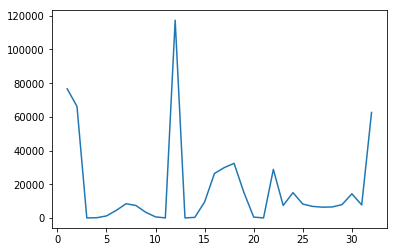

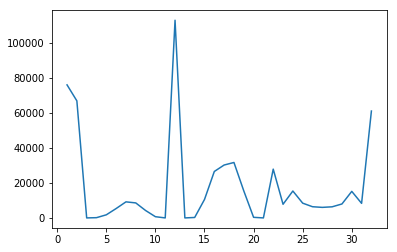

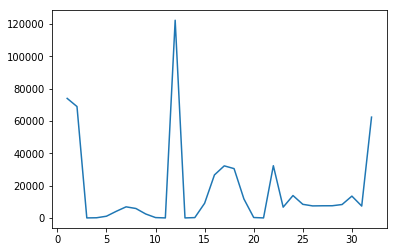

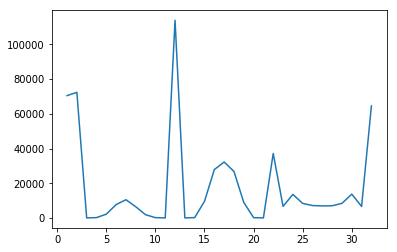

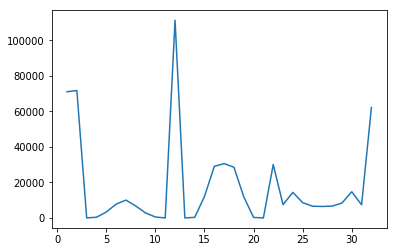

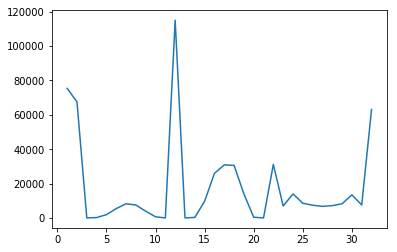

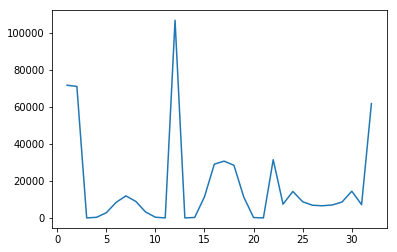

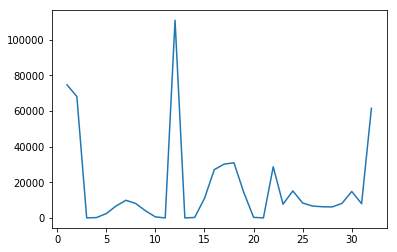

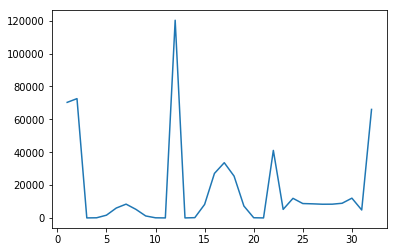

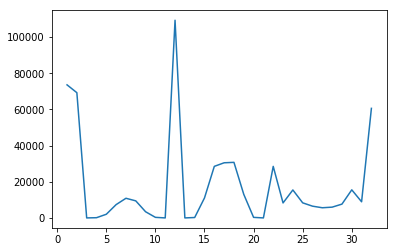

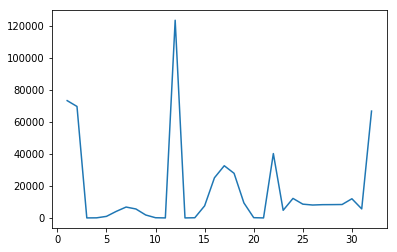

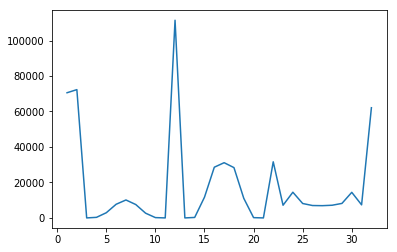

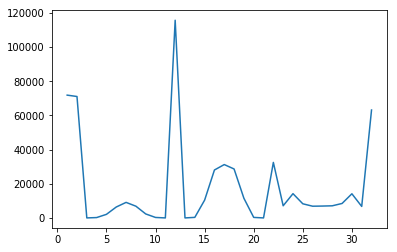

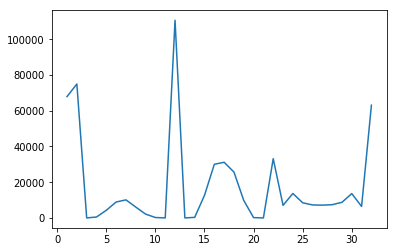

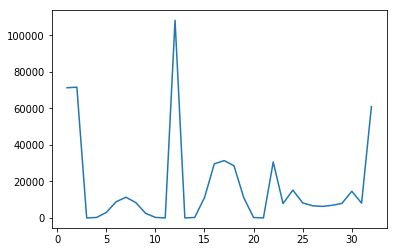

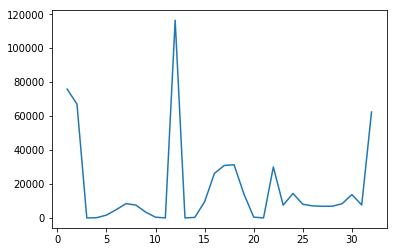

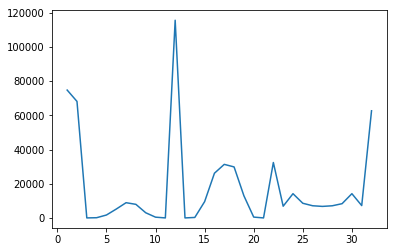

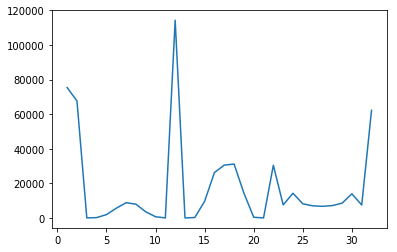

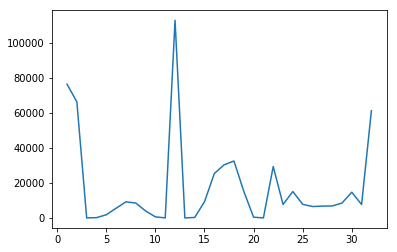

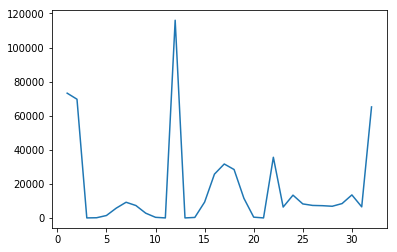

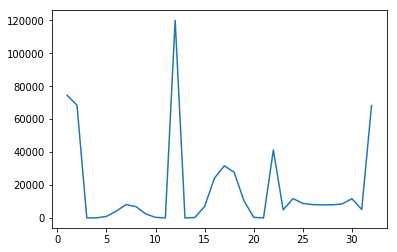

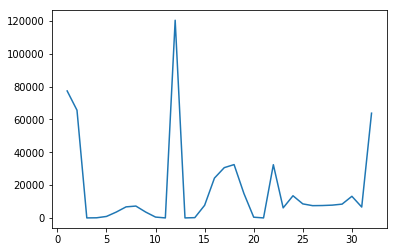

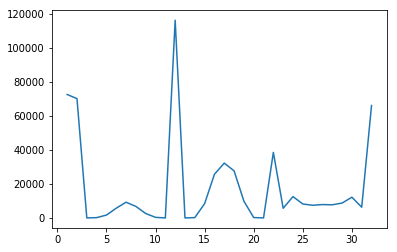

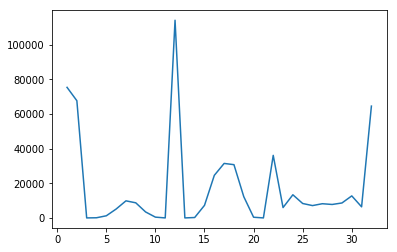

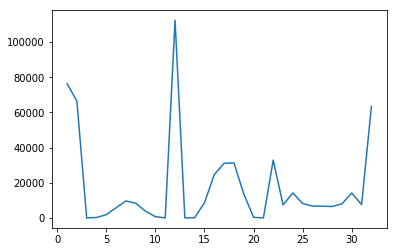

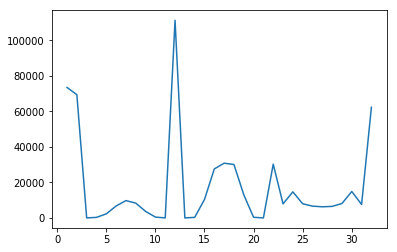

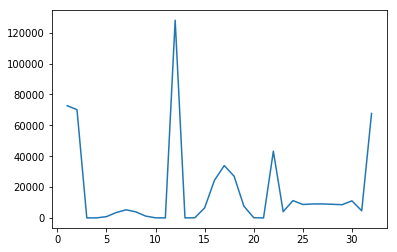

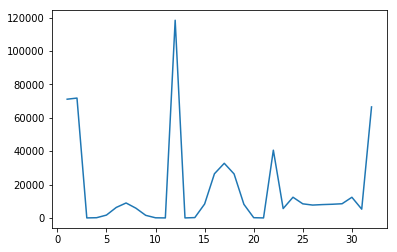

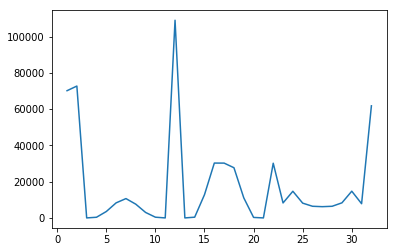

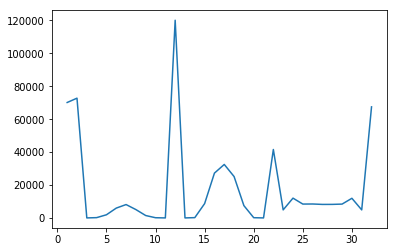

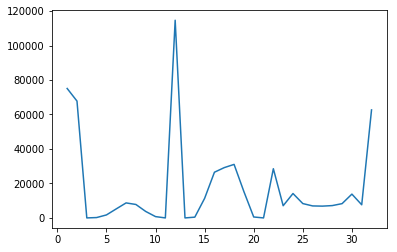

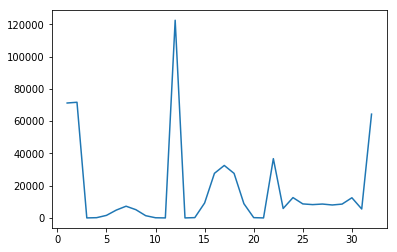

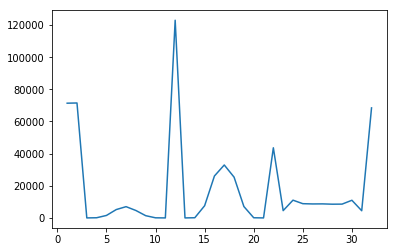

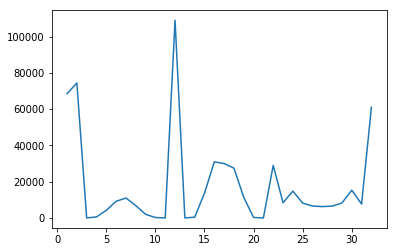

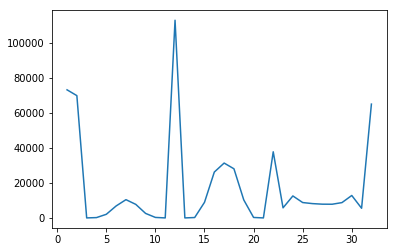

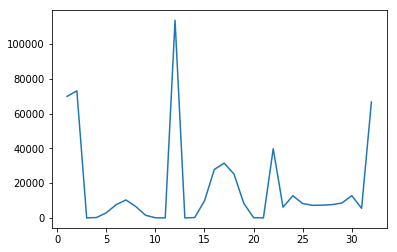

In [35]:
featurepath = r'Z:\3DHistoData\Grading\LBP_features_python.xlsx'
features = pd.read_excel(featurepath, 'LBP_features')
features = pd.DataFrame(features).values.astype('int')
print(features.shape)
x = np.linspace(1, 32, num=32)
for i in range(features.shape[1]):
    plt.plot(x, features[:,i])
    plt.show()

In [5]:
w, ncomp, eigenvec, signularvalues, weights, mean = loadbinaryweights(r'Z:\3DHistoData\Grading\_deepne_weights.dat')
print(w)
print(ncomp)
print(eigenvec)
print(weights)
print(mean)

32
20
[[-2.12098226e-01  2.99136639e-01 -5.53756595e-01  2.88078915e-02
  -7.10378587e-02  2.09759116e-01 -2.35892227e-03  3.86586189e-02
   2.33784225e-02 -2.39751991e-02  3.93138751e-02  2.19707843e-02
   3.43014039e-02  5.17754257e-03 -6.08007750e-03 -3.49793583e-02
  -2.14962773e-02 -1.77708212e-02 -5.23303112e-04  2.69503482e-02]
 [ 2.12098226e-01 -2.99136639e-01  5.53756595e-01 -2.88078915e-02
   7.10378587e-02 -2.09759116e-01  2.35892227e-03 -3.86586189e-02
  -2.33784225e-02  2.39751991e-02 -3.93138751e-02 -2.19707843e-02
  -3.43014039e-02 -5.17754257e-03  6.08007750e-03  3.49793583e-02
   2.14962773e-02  1.77708212e-02  5.23303112e-04 -2.69503482e-02]
 [-1.11022302e-16  0.00000000e+00  2.22044605e-16  8.41340886e-17
   1.00613962e-16  6.93889390e-17  3.20707003e-16 -1.90819582e-16
  -2.34187669e-16  9.88792381e-17  1.11022302e-16  1.09114107e-15
  -1.03389519e-15  9.17668719e-16  6.93889390e-18 -3.05311332e-16
  -1.64278313e-15 -7.07767178e-16 -2.42424895e-15 -3.06525638e-15]
 

   2.98490413e-02 -2.98538581e-02 -3.39505076e-02 -9.97985899e-02]]
[ 0.15867898  0.10951782  0.00606123 -0.034456    0.03244523  0.19631977
  0.03057923 -0.01203068 -0.02861139  0.02047173  0.00068893 -0.13703889
 -0.02182898 -0.03631262  0.0387038  -0.07532691 -0.1050587   0.13114254
  0.03807065  0.16018437]
[ 61690.05555556  63625.94444444      0.            170.63888889
   2068.44444444   6802.61111111   9289.38888889   6091.16666667
   1790.86111111    160.72222222      0.          98942.16666667
      0.            215.75         1870.86111111   5757.5
   7971.16666667   5339.30555556   1597.16666667    171.88888889
      0.         102392.36111111    550.44444444   3982.80555556
   4366.16666667   4544.88888889   4670.16666667   4624.94444444
   4416.02777778   4206.25          578.91666667  93375.38888889]


In [42]:
a = np.array([[1, 2, 3, 4, 5, 6], [11, 12, 13, 14, 15, 16]])
b = np.array([2, 2, 2, 3, 3, 3])
print(a/b)

[[0.5        1.         1.5        1.33333333 1.66666667 2.        ]
 [5.5        6.         6.5        4.66666667 5.         5.33333333]]
